In [1]:
import distutils
import distutils.util
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import os.path as opath
import ast
import json
from pandas.io.json import json_normalize
import datetime
import pickle
import re
from datetime import datetime
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

<div class="span5 alert alert-info">
<h2>Note book details</h2>

<p> This notebook is for <b>data story</b> for <b>kickstarter success prediction</b> project.</p>

<p> Notes.</p>
<ol>
<li>  The file will utlize the pickle file crated in third part of for data wrangling</li> 
<li>  The file will perform exploratory analysis on the kickstarter data with some </li> 
<li>  The file will address the question with explanation  during analysis</li> 
<li>  The Questions analyzed are as follows: 
    <ul>
     <li>Question 1 : What is project count as per project status? What is successful and failed ratio ?</li>
     <li>Question 2 : Is there relationship with year,month of launch date for successful or Failed?</li>
     <li>Question 3 : Is there relationship with goal amount in success of failure of  project?</li>
     <li>Question 4 : Is there relationship with pledge amount in success of failure of  project?</li>
     <li>Question 5 : Is there relationship with pldege to goal ration in success of failure of  project?</li>
     <li>Question 6 : Is there relationship with pldege to no of backers ration in success of failure of  project?</li>
     <li>Question 7 : Is there relationship with no of backers in success of failure of  project?</li>
     <li>Question 8 : Which country are having most and least successful or failed project?</li>
     <li>Question 9 : Does staff pick maked more successful projects?</li>
	 <li>Question 10 : What categories are having most and least successful or failed project?</li>
     <li>Question 11 : What location type are having most and least successful or failed project?</li>
    </ul>
</li>        
</ol>
</div>

## Setting common values for graph

In [2]:
pd.set_option('display.max_colwidth', -1)
color_success='#00ff66'#kickstarter green#'#2BDE73'
color_fail='#FF192F'#'#FFC7CE'#'#FFC7CE'#'#FF0000' # red
'''graph_color_palette=[
    color_success, #kickstarter green#'#2BDE73'
    '#55ee99',# kickstarete light green
    'brown',
    'grey'
    ,color_fail # red
]
'''
stateSuccess='Successful'
stateFail='Failed'

"graph_color_palette=[\n    color_success, #kickstarter green#'#2BDE73'\n    '#55ee99',# kickstarete light green\n    'brown',\n    'grey'\n    ,color_fail # red\n]\n"

In [3]:
# from IPython.core.display import HTML
css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))
pickle_file='DataStory_Jan2017_Jan2018.sa'
df_final_months = pickle.load( open( pickle_file, "rb" ) )
#df_final_months.info()
#df_final_months.head()

## Helper methods for data manipulation for building graphs

In [4]:
def calculate_ratio(numerator, denominator):
    ratio=0
    if(denominator>0).any():
        ratio=numerator/denominator
    return np.round(ratio,3)

In [5]:
def convertToPercentage(val):
    return val*100

In [6]:
def get_days_difference(date_from, date_to):
    print(date_from-date_to)#.days

In [7]:
def compare_dates(from_date, to_date):
    date_format = '%Y-%m-%d %H:%M:%S'#'%Y/%m/%d'
    from_date_val = datetime.strptime(from_date, date_format)  
    to_date_val= datetime.strptime(to_date, date_format)  
    #today = datetime.today()
    diff = from_date_val - to_date_val
    return diff.days

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [9]:
def convertToDateFormat(val):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(val,date_format)

def convertCreateDateToDateFormat(row):
    return convertToDateFormat(row)
    
    
def getMonth(row):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(row.launched_at,date_format).month
    #print (type(row.created_at))
def getYear(row):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(row.launched_at,date_format).year

In [10]:
def autolabel(rects,format='%d'):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                format % (height),
                ha='center', va='bottom')

In [11]:
def extratDataFrameByGroup(gdata,state,grpColumn,blargest,noofitem,column):
    #gdata[gdata.state=='successful'].groupby(['category']).count().nlargest(10,'state').reset_index()
    res =gdata[gdata.state==state].groupby([grpColumn]).count()
    if(blargest):
        return res.nlargest(noofitem,column).reset_index()
    else:
        return res.nsmallest(noofitem,column).reset_index()

In [12]:
def drawbarplot(gdata,ycol,xcol,color,axis,ylabel,xlabel,title):
    _=axis.set_title(title)
    factor=0.5
    g=sns.barplot(data=gdata,y=ycol,x=xcol,color=color,ax=axis)
    #_=g.fig.suptitle(title)
    _=g.set(xlabel=xlabel, ylabel=ylabel)
    for index, row in gdata.iterrows():
        g.text(row[xcol]+factor,row.name,  row[xcol], color='black', ha="center")
    
    return g

In [13]:
start=0
step=100
stop=10001
#bins_range=[0, 10, 20, 30, 40, 50, 100,110,120,130,140,150,160,170,180,190,200]#range(start, step ,stop)
bins_range=list(range(start ,stop, step))
#bins_range

# Make dataframes for graphs

In [14]:
# filter out suspened, cancleed and live projects
df_fail_success= df_final_months[(df_final_months.state==stateSuccess) | (df_final_months.state==stateFail)]
_=df_fail_success.set_index('project_id')
#df_fail_success.head()

##  Graphs Starts

<div class="span5 alert alert-info">
<h4>
Question 1 : What is project count as per project status? What is successful and failed ratio ?</h4>
</div>

### Project state  

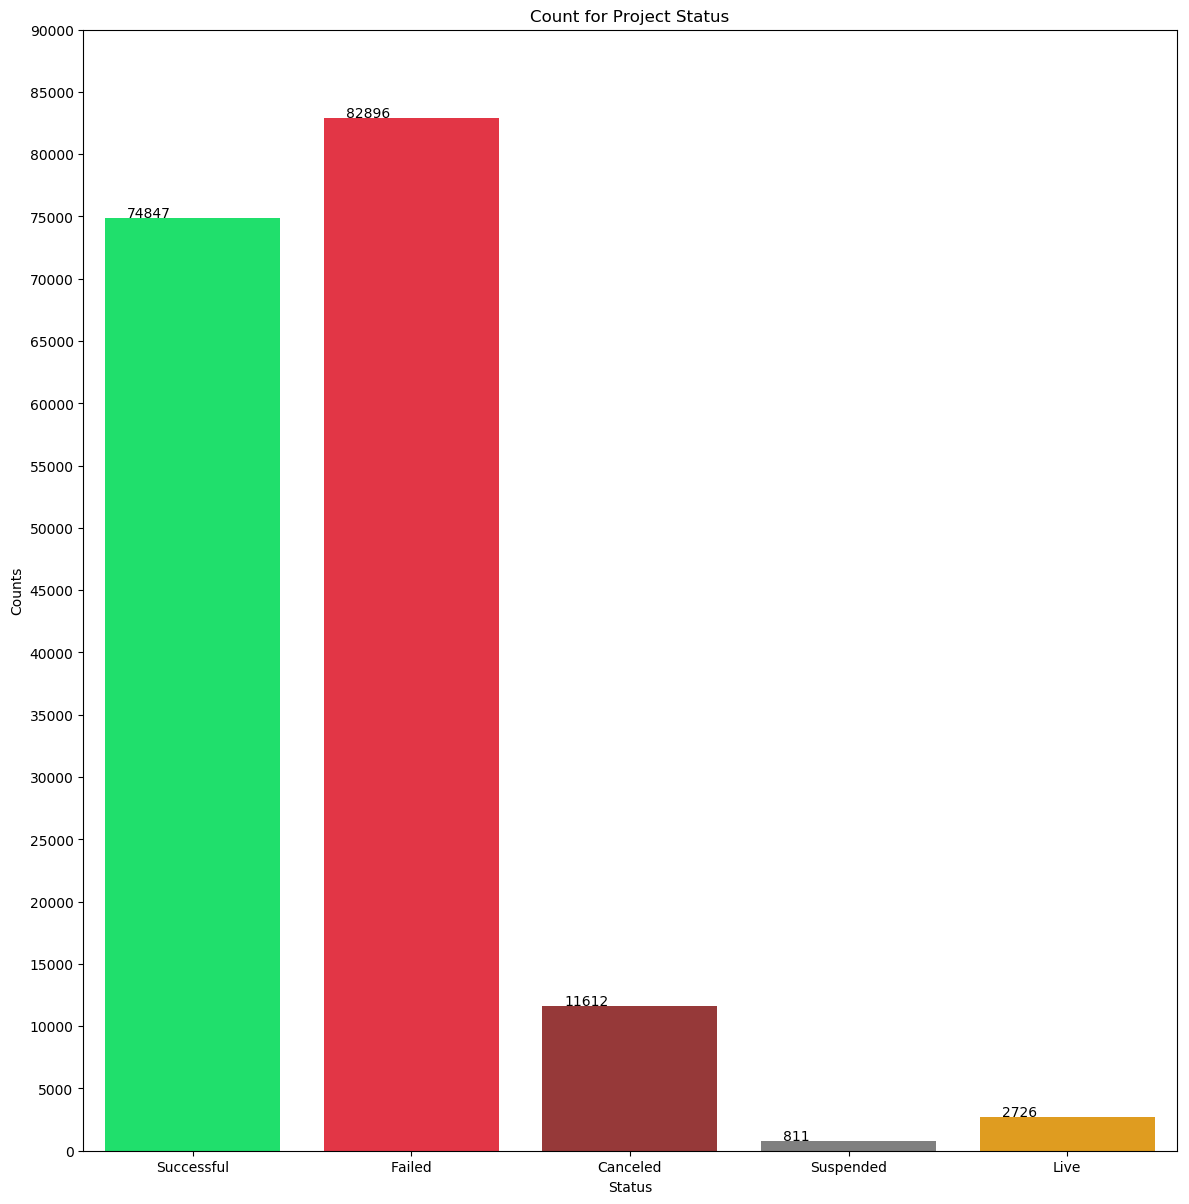

In [15]:
statuspalette=[
    color_success, #kickstarter green#'#2BDE73'
    color_fail, # red
    'brown',
    'grey',
'orange',# kickstarete live
]
fig, axis = plt.subplots(1,1,figsize=(12,12),dpi=100)
axis=sns.countplot(x='state',data=df_final_months,palette=statuspalette)
_=plt.yticks(np.arange(0, 90001, 5000))
#_=plt.xlabel('Project Status')
#_=plt.ylabel('Counts')
_=plt.tight_layout()

ylabel='Counts'
xlabel='Status'
title = 'Count for Project Status'
_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_title(title)
#plt.savefig('test.png')
for p in axis.patches:
        _=axis.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

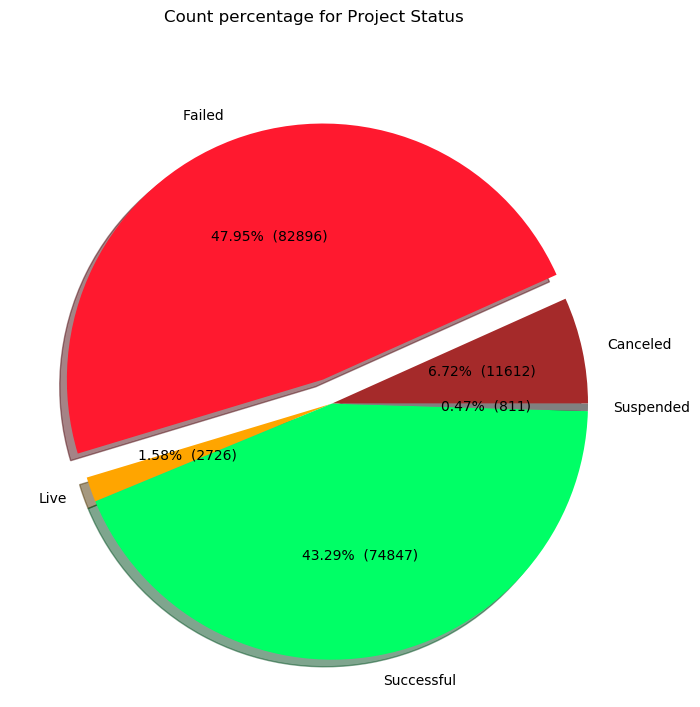

In [16]:
state_count=df_final_months.groupby(df_final_months.state).size()
explode = (0, 0.1, 0, 0,0)  # only "explode" the fail slice
statuspalette=[
    'brown',
    color_fail, # red
    'orange',# kickstarete live
    color_success,#kickstarter green#'#2BDE73'
    'grey', 
]

fig, axis = plt.subplots(1,1,figsize=(8,8),dpi=100)
labels=np.sort(df_final_months.state.unique())
_=plt.pie(state_count,explode=explode,labels=labels,colors=statuspalette,shadow=True,autopct=make_autopct(state_count) )
# Set aspect ratio to be equal so that pie is drawn as a circle.
_=plt.axis('equal')
#_=plt.tight_layout()
fig.suptitle("Count percentage for Project Status")


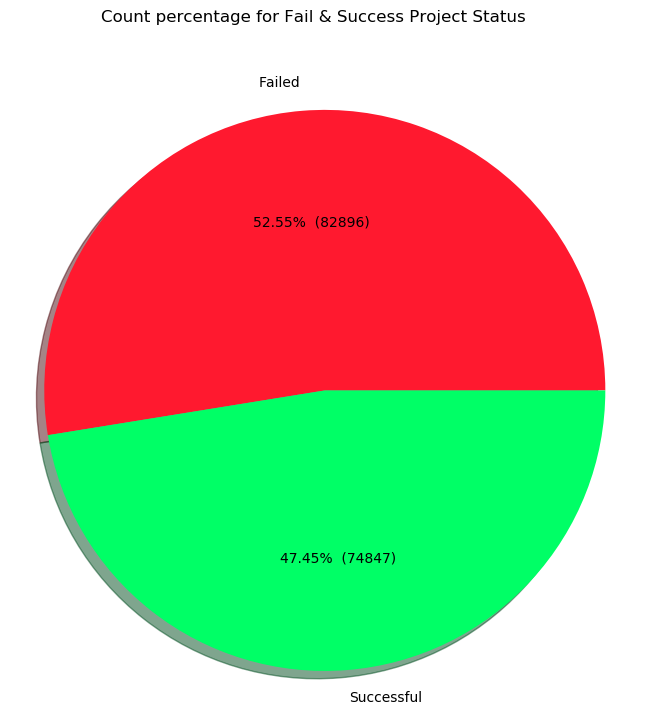

In [17]:
state_count=df_fail_success.groupby(df_final_months.state).size()
explode = (0, 0) 
statuspalette=[
    color_fail, # red
    color_success,#kickstarter green#'#2BDE73'
]
labels=np.sort(df_fail_success.state.unique())
fig, axis = plt.subplots(1,1,figsize=(8,8),dpi=100)
_=plt.pie(state_count,explode=explode,labels=labels,colors=statuspalette,shadow=True,autopct=make_autopct(state_count))#,autopct='%.2f' )
_=plt.axis('equal')

fig.suptitle("Count percentage for Fail & Success Project Status")

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : What is project count as per project status? What is successful and failed ratio ?</h4>
    <ul>
     <li> Most project belongs to Success and Failed Status. The status Canceled and Suspended are negligible </li> 
     <li> The status Live is for status still active and should be filtered  </li> 
     <li> There are more Failed then Successful projects but have very close numbers </li> 
    </ul>
</div>

### Months and year

<div class="span5 alert alert-info">
<h4>
Question 2 : Is there relationship with year,month of launch date for successful or Failed?</h4>
</div>

## Heat map for success

In [18]:
#gdata=df_fail_success[['created_at' ,'category' , 'state']]#[0:10]

gdata=df_fail_success.loc[:,['launched_at' ,'category' , 'state']]#[0:10]
gdata['Launch_month']=gdata.apply(getMonth,axis=1)
gdata['Launch_year']=gdata.apply(getYear,axis=1)

gdataSuccess=gdata[gdata.state==stateSuccess]
gdataSuccess=gdataSuccess.groupby(['Launch_year','Launch_month']).count()
gdataSuccess=gdataSuccess.reset_index()

gdataFail=gdata[gdata.state==stateFail]
gdataFail=gdataFail.groupby(['Launch_year','Launch_month']).count()
gdataFail=gdataFail.reset_index()
monthlist =('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
yearlist=('2009','2010','2011','2012','2013','2014','2015','2016','2017')

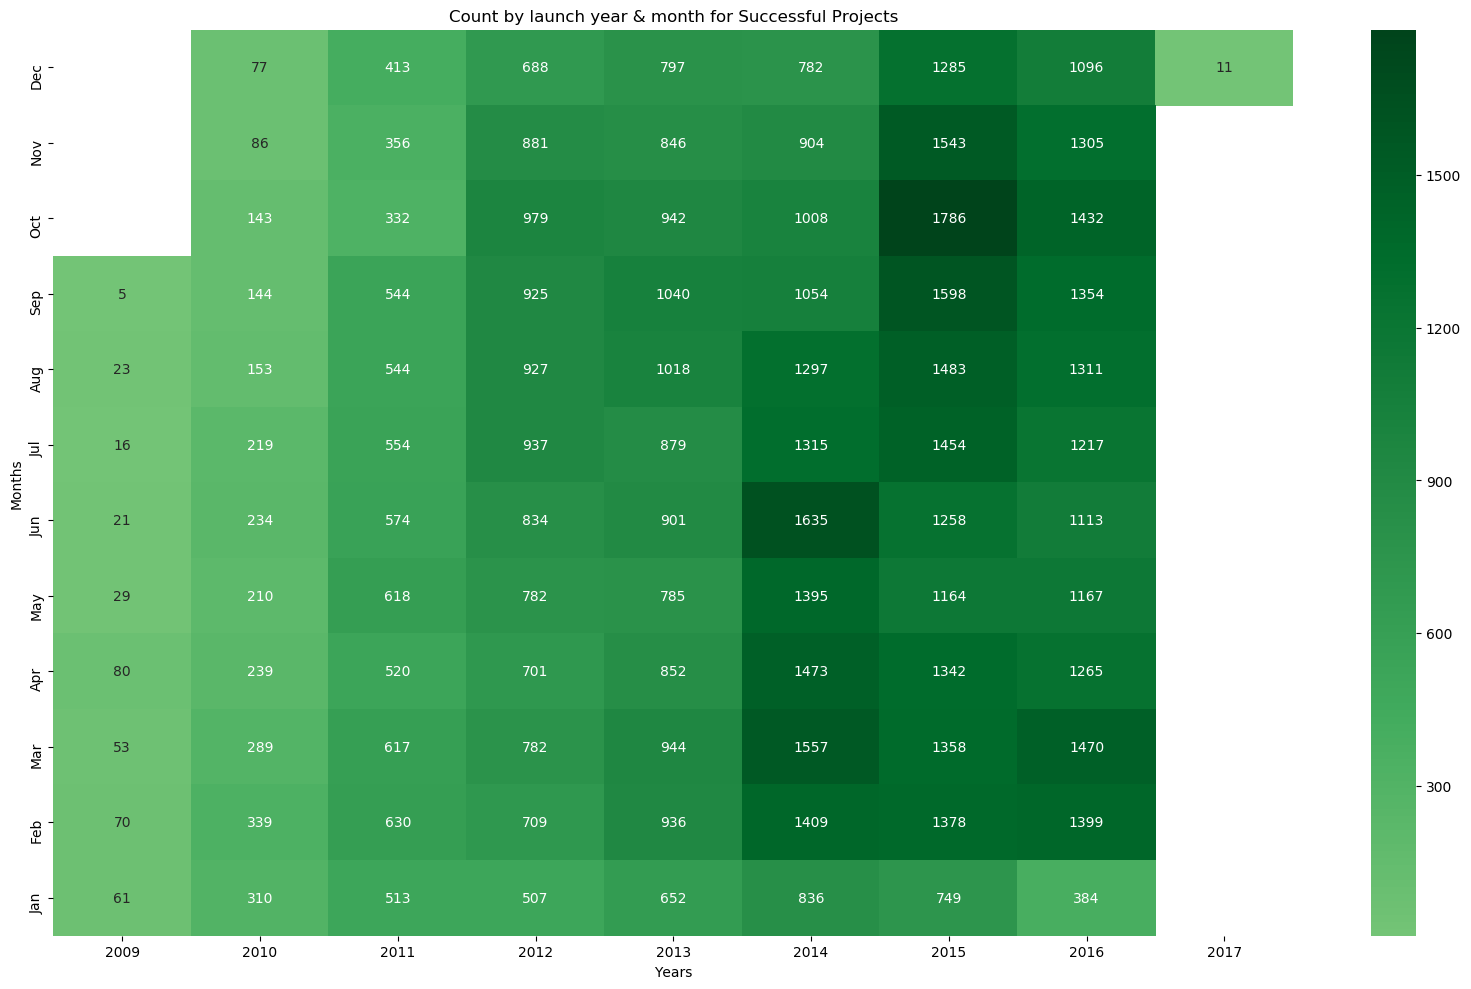

In [19]:
t = gdataSuccess.pivot("Launch_month", "Launch_year", "state")
fig, axis = plt.subplots(1,1,figsize=(20,12),dpi=100)

axis = sns.heatmap(t,center=0,annot=True,fmt='.0f',cmap="Greens")

ylabel='Months'
xlabel='Years'
title = 'Count by launch year & month for Successful Projects'
_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_yticklabels(monthlist[::-1])
_=axis.set_title(title)

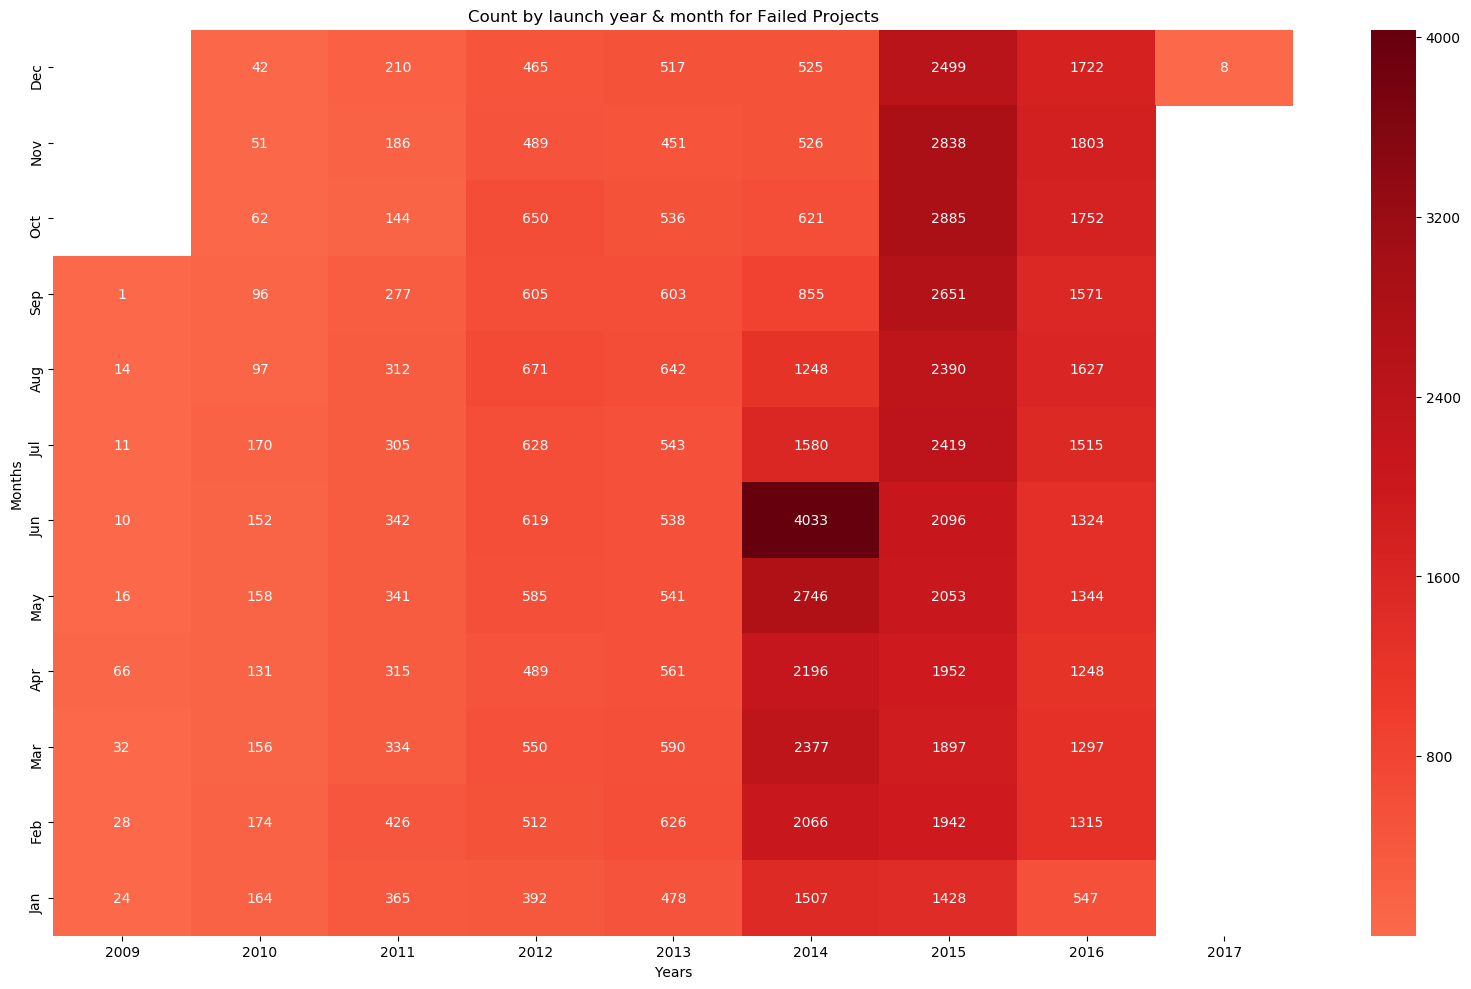

In [20]:
t = gdataFail.pivot("Launch_month", "Launch_year", "state")
fig, axis = plt.subplots(1,1,figsize=(20,12),dpi=100)

axis = sns.heatmap(t,center=0,annot=True,fmt='.0f',cmap="Reds")
ylabel='Months'
xlabel='Years'
title = 'Count by launch year & month for Failed Projects'
_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_yticklabels(monthlist[::-1])
_=axis.set_title(title)

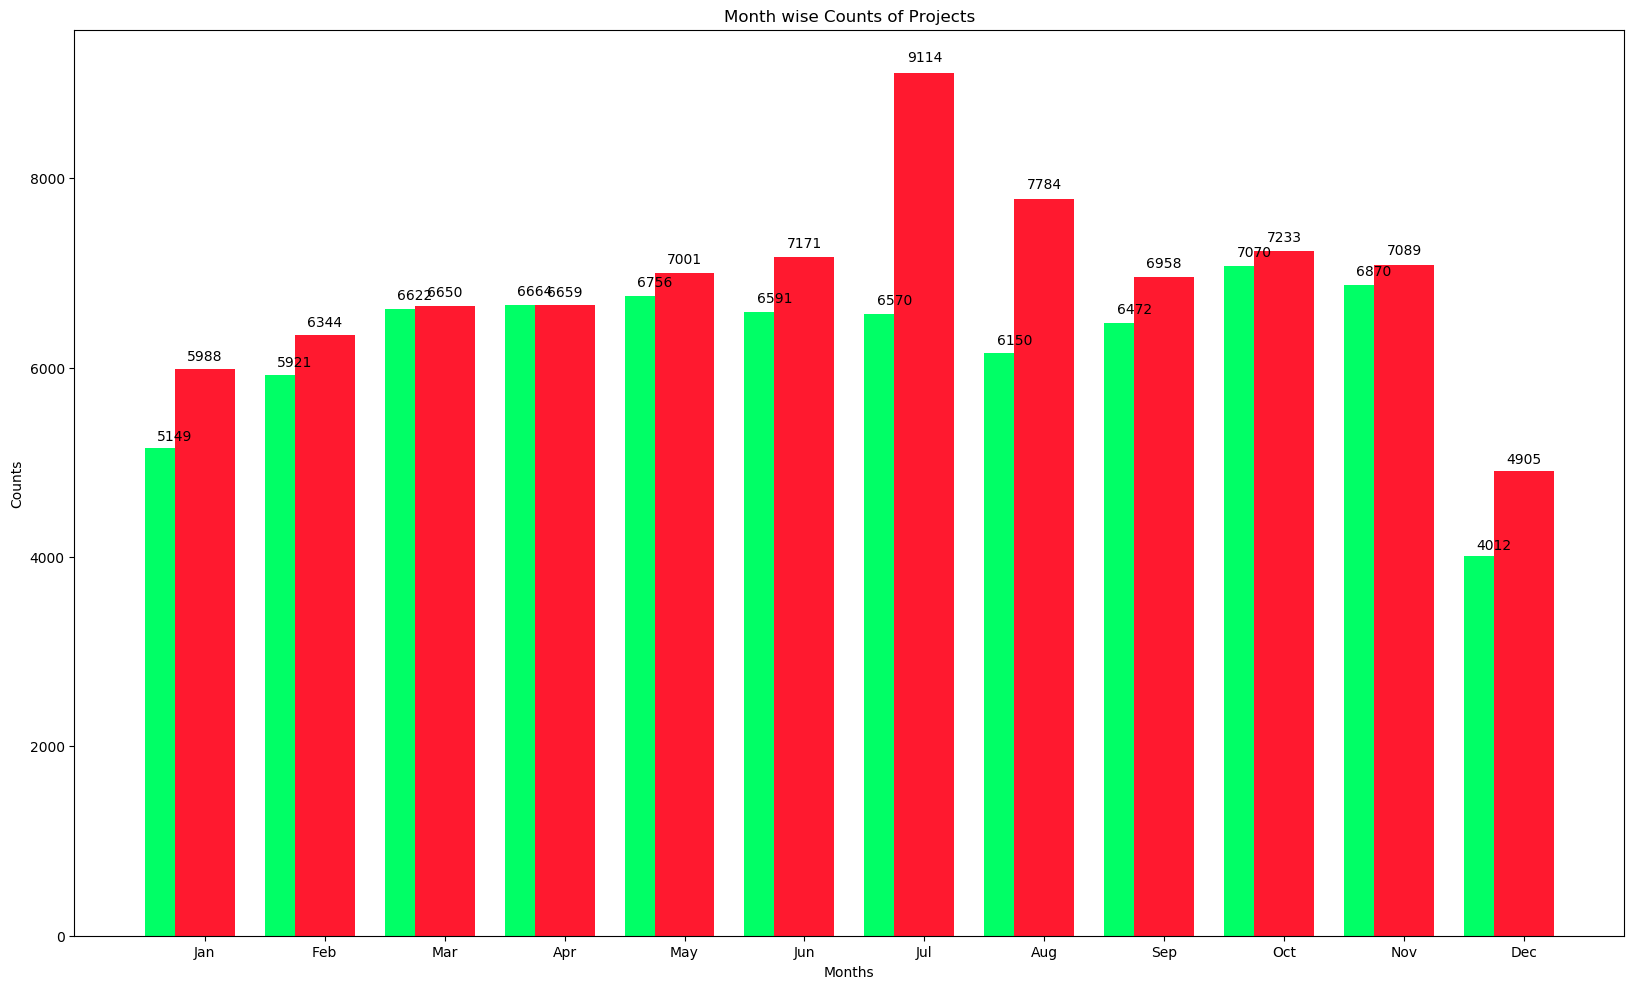

In [21]:
ysuccess=gdataSuccess.groupby(gdataSuccess.Launch_month).sum()
yFail=gdataFail.groupby(gdataFail.Launch_month).sum()
#t.plot(kind='bar',colormap='RdYlGn')
width = 0.50       # the width of the bars

ind = np.arange(12)

fig, ax = plt.subplots(1,1,figsize=(20,12),dpi=100)
rects1 = ax.bar(ind, ysuccess.state, width, color=color_success)#, yerr=men_std)
rects2 = ax.bar(ind + width/2, yFail.state, width, color=color_fail)#, yerr=women_std)

# add some text for labels, title and axes ticks
_=ax.set_xticks(ind + width / 2)
_=ax.set_xticklabels(monthlist)

autolabel(rects1)
autolabel(rects2)

xlabel='Months'
ylabel='Counts'
title = 'Month wise Counts of Projects'

_=ax.set_ylabel(ylabel)
_=ax.set_xlabel(xlabel)
_=ax.set_title(title)

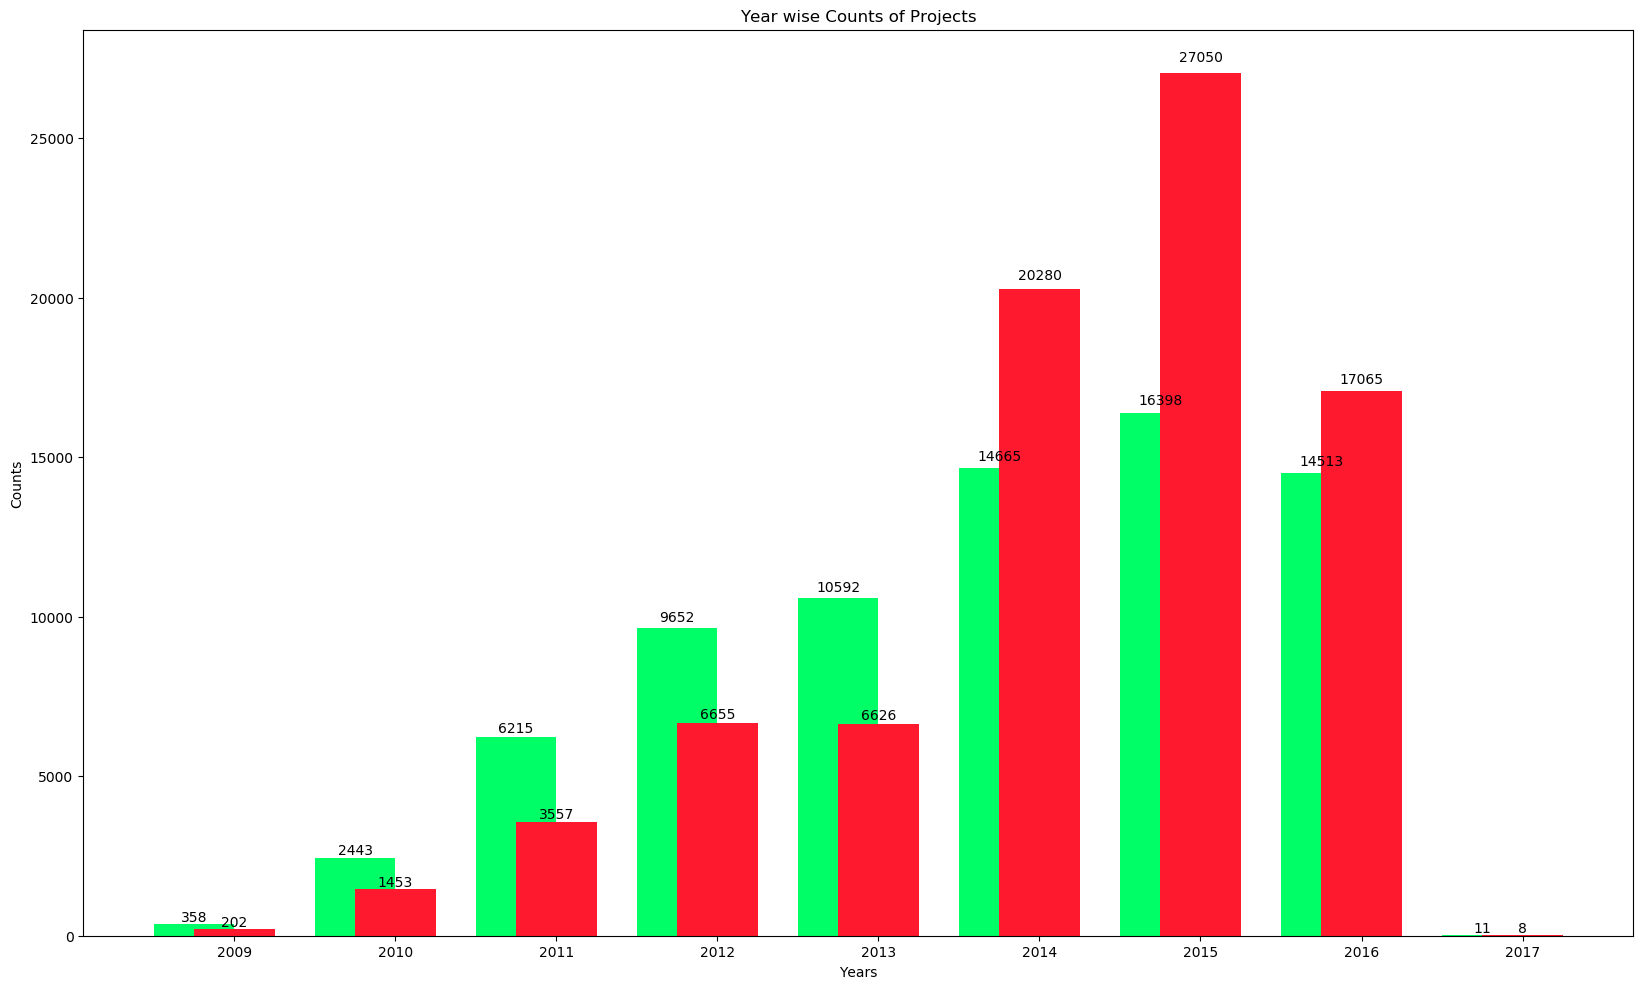

In [22]:
ysuccess=gdataSuccess.groupby(gdataSuccess.Launch_year).sum()
yFail=gdataFail.groupby(gdataFail.Launch_year).sum()
#t.plot(kind='bar',colormap='RdYlGn')
width = 0.50       # the width of the bars

ind = np.arange(9)

fig, ax = plt.subplots(1,1,figsize=(20,12),dpi=100)
rects1 = ax.bar(ind, ysuccess.state, width, color=color_success)#, yerr=men_std)
rects2 = ax.bar(ind + width/2, yFail.state, width, color=color_fail)#, yerr=women_std)

# add some text for labels, title and axes ticks
_=ax.set_xticks(ind + width / 2)
_=ax.set_xticklabels(yearlist)

autolabel(rects1)
autolabel(rects2)

xlabel='Years'
ylabel='Counts'
title = 'Year wise Counts of Projects'

_=ax.set_ylabel(ylabel)
_=ax.set_xlabel(xlabel)
_=ax.set_title(title)

In [23]:
# make data frame for percentage for year wise growth
_=ysuccess.rename(columns={'state': 'state_success'}, inplace=True)
_=yFail.rename(columns={'state': 'state_fail'}, inplace=True)
result = pd.concat([ysuccess, yFail], axis=1)

result=result.assign(
    year_success_ratio=lambda row:convertToPercentage( calculate_ratio((row.state_success),(row.state_success+row.state_fail))))

result=result.assign(
    year_fail_ratio=lambda row: convertToPercentage(calculate_ratio((row.state_fail),(row.state_success+row.state_fail))))

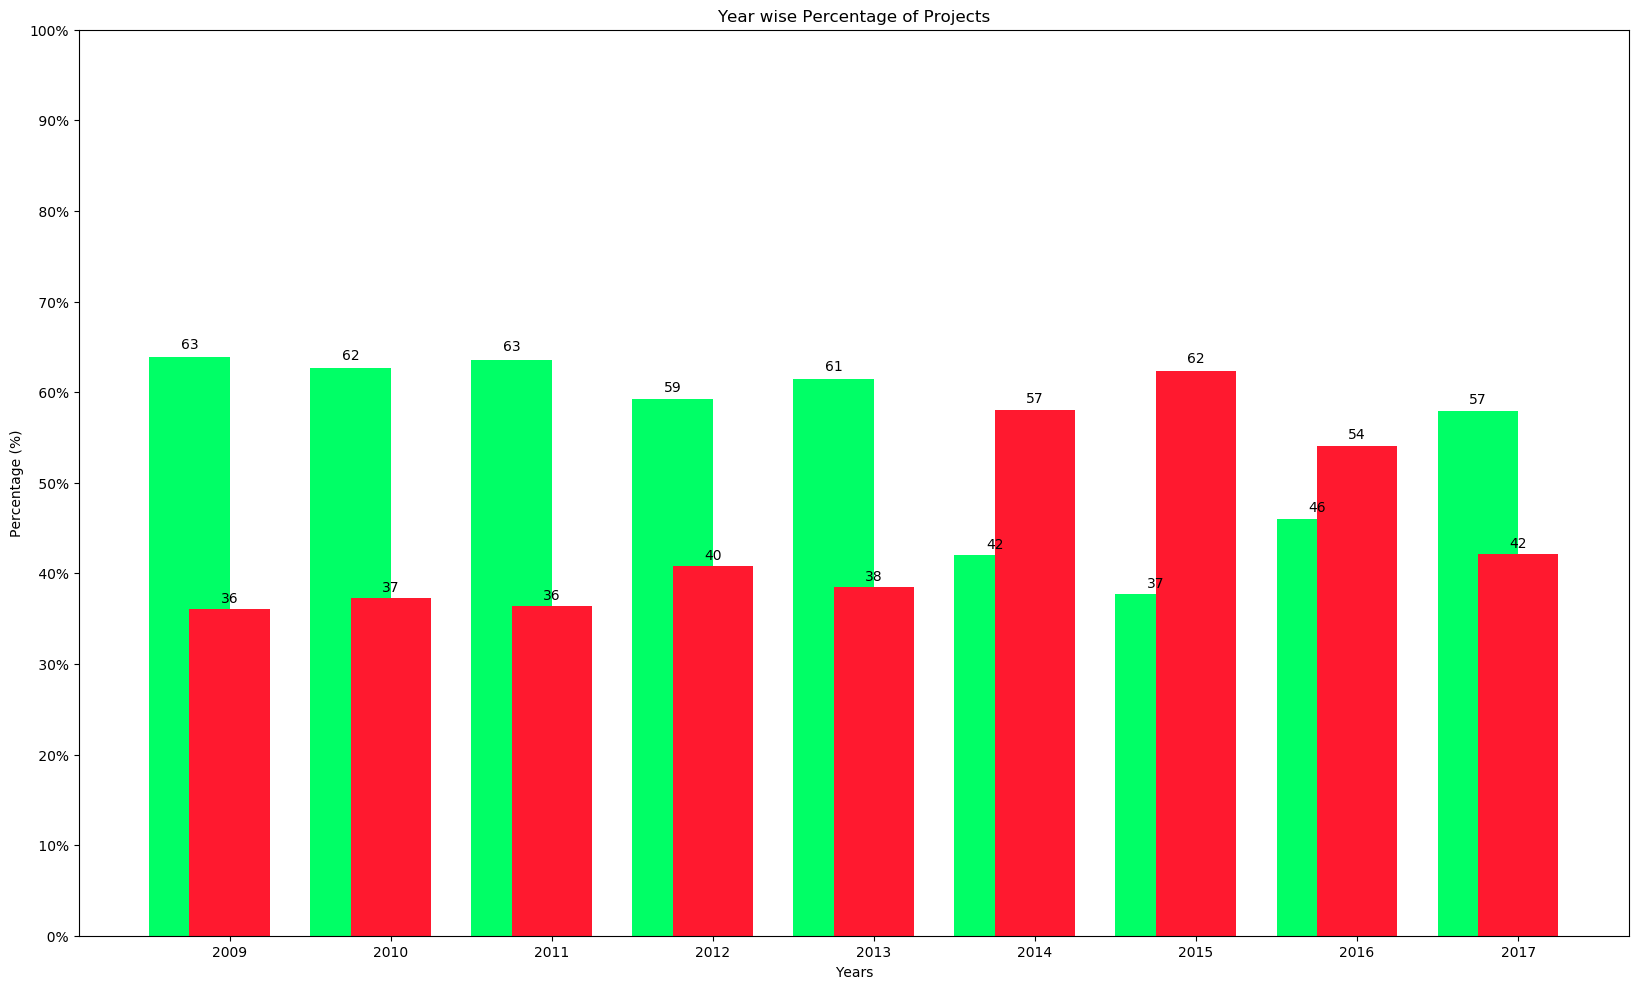

In [24]:
width = 0.50       # the width of the bars

ind = np.arange(9)

fig, ax = plt.subplots(1,1,figsize=(20,12),dpi=100)
rects1 = ax.bar(ind, result.year_success_ratio, width, color=color_success)#, yerr=men_std)
rects2 = ax.bar(ind + width/2, result.year_fail_ratio, width, color=color_fail)#, yerr=women_std)

# add some text for labels, title and axes ticks
_=ax.set_xticks(ind + width / 2)
_=ax.set_xticklabels(yearlist)

perc = np.arange(0, 101, 10)

_=ax.set_yticks(perc)
_=ax.set_yticklabels(['{:3.0f}%'.format(x) for x in  perc])

autolabel(rects1)
autolabel(rects2)

xlabel='Years'
ylabel='Percentage (%)'
title = 'Year wise Percentage of Projects'

_=ax.set_ylabel(ylabel)
_=ax.set_xlabel(xlabel)
_=ax.set_title(title)

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion :  Is there relationship with year,month of launch date for successful or Failed?</h4>
    <ul>
     <li> The projects are launched evenly all months around with few months have spike in numbers </li> 
     <li> Every month more projects are failed but still the counts are close </li> 
     <li> Kicstarter was launched in 2009. There was steady growth in number of projects started till 2015. This is not very sure as data is only available til 2017  </li> 
     <li> Not sufficent data available from 2017 and onward</li>
     <li> There is indication that kickstarter more project failed as years progressing</li>
     <li> There is indication that kickstarter is getting less popular and interest is on decline</li>
    </ul>
</div>

<div class="span5 alert alert-info">
<h4>
Question 3 : Is there relationship with goal amount in success of failure of  project?</h4>
</div>

In [25]:
#gdata=df_fail_success[['usd_goal','usd_pledged','state']]
gdata=df_fail_success.loc[:,['usd_goal','usd_pledged','state','goal','pledged','pledge_count_ratio','pledge_goal_ratio','pledge_extra_goal_ratio','backers_count']]

gdataSuccess=gdata[gdata.state==stateSuccess]
gdataFail=gdata[gdata.state==stateFail]
#gdata.info()

### Goal Amount

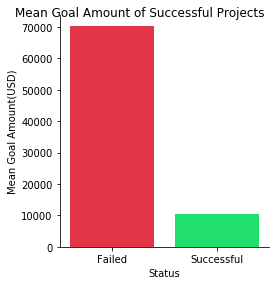

In [26]:
#fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
temp=gdata.loc[:,['usd_goal','state']]
temp=temp.groupby('state').mean()
temp['state']=temp.index
#gdata
#temp

xlabel='Status'
ylabel='Mean Goal Amount(USD)'
title = 'Mean Goal Amount of Successful Projects'


g=sns.factorplot(data=temp,x='state',y='usd_goal',palette=statuspalette,kind='bar')
_=g.fig.suptitle(title)
_=g.set(xlabel=xlabel, ylabel=ylabel)

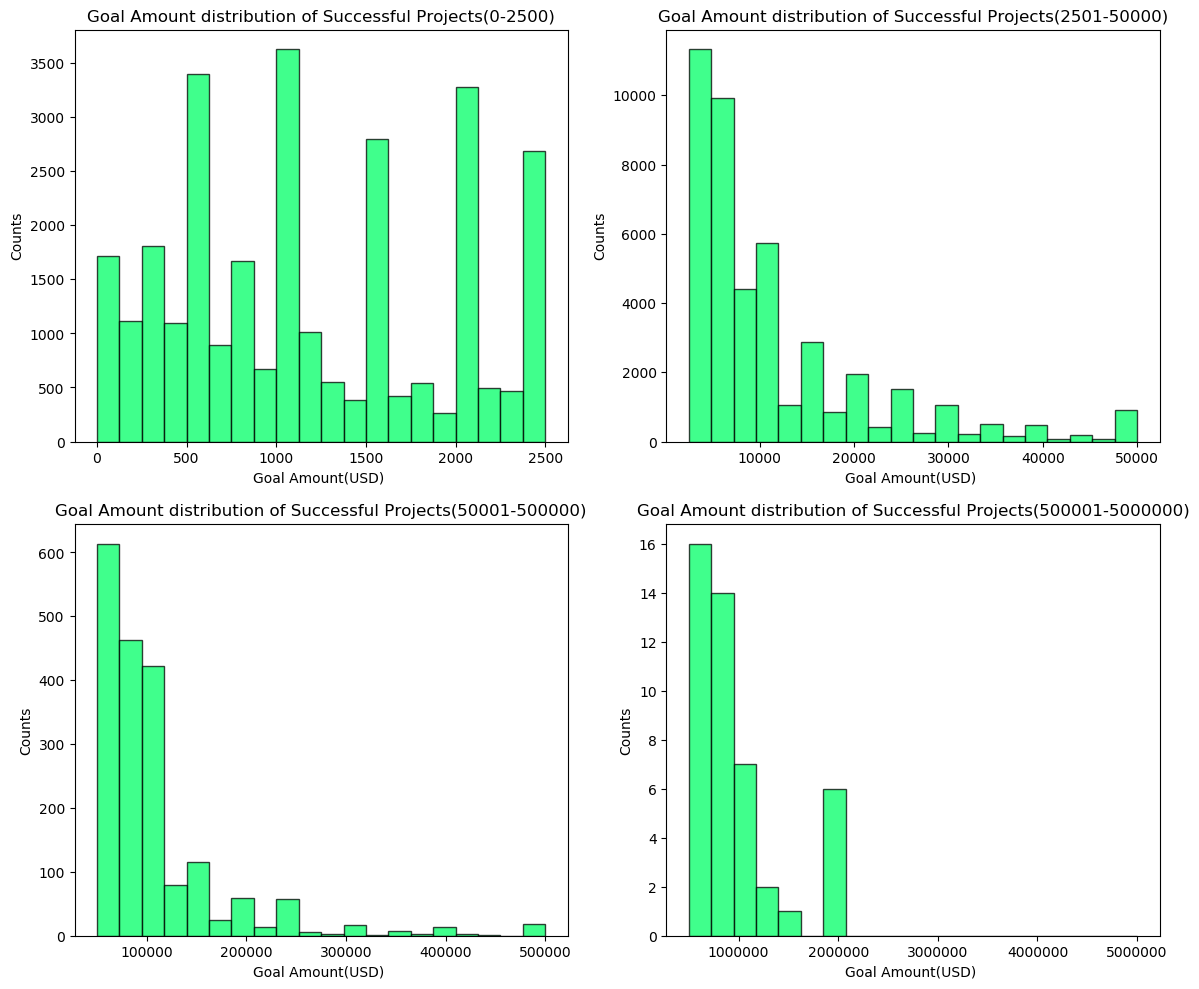

In [27]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Goal Amount(USD) '
ylabel='Counts'
title = 'Goal Amount distribution of Successful Projects{}'

ranges =[0,2500]
_=ax[0][0].hist(gdataSuccess.usd_goal, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-2500)'))

ranges =[2501,50000]
_=ax[0][1].hist(gdataSuccess.usd_goal, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(2501-50000)'))

ranges =[50001,500000]
_=ax[1][0].hist(gdataSuccess.usd_goal, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(50001-500000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataSuccess.usd_goal, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(500001-5000000)'))

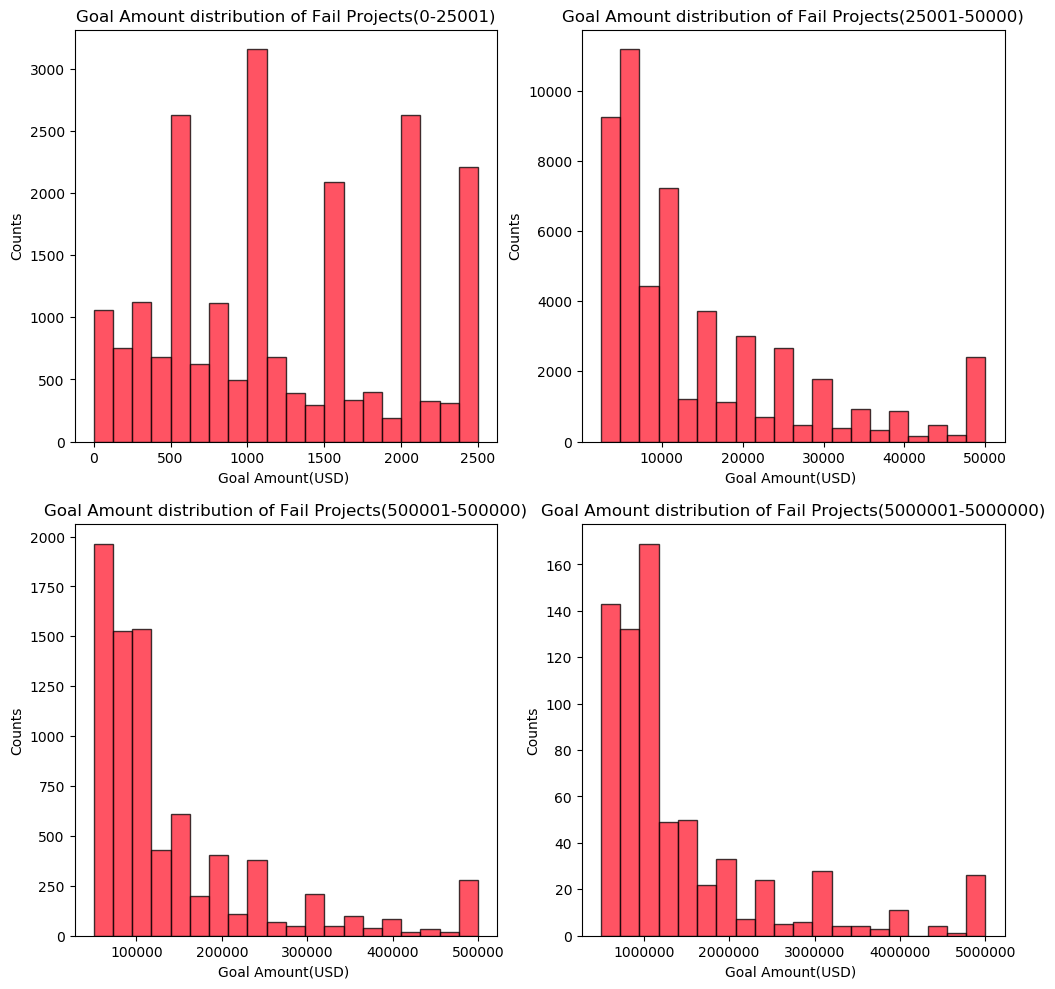

In [28]:
fig, ax = plt.subplots(2,2,figsize=(12,12),dpi=100)
bins=20

xlabel='Goal Amount(USD) '
ylabel='Counts'
title = 'Goal Amount distribution of Fail Projects{}'

ranges =[0,2500]
_=ax[0][0].hist(gdataFail.usd_goal, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-25001)'))

ranges =[2501,50000]
_=ax[0][1].hist(gdataFail.usd_goal, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(25001-50000)'))

ranges =[50001,500000]
_=ax[1][0].hist(gdataFail.usd_goal, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(500001-500000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataFail.usd_goal, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5000001-5000000)'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Is there relationship with goal amount in success of failure of  project?</h4>
    <ul>
     <li> The average goal amount of failed project is seven times higher  </li> 
     <li> The average goal amount of successful project is 10000   </li> 
     <li> The average goal amount of failed project is 70000  </li> 
      <li> Most succesful projects have goal amount in range of 2500-5000  </li>
      <li>More project are successful when goal amount is low. There are less successful projects in higher goal amount </li>
       <li> Most failed projects have goal amount in range of 5000-7000  </li>
      <li>More project failed when goal amount increases. There are less failed projects in lower goal amount</li>
      <li>Goal amount has impact on the success and failure</li>
    </ul>
</div>

### Pledge Amount

<div class="span5 alert alert-info">
<h4>
Question 4 : Is there relationship with pledge amount in success of failure of  project?</h4>
</div>

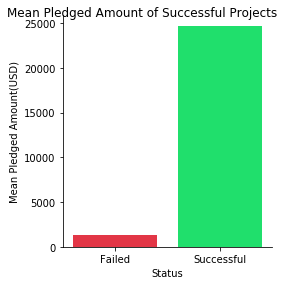

In [29]:
#fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
temp=gdata.loc[:,['usd_pledged','state']]
temp=temp.groupby('state').mean()
temp['state']=temp.index
#gdata
#temp

xlabel='Status'
ylabel='Mean Pledged Amount(USD)'
title = 'Mean Pledged Amount of Successful Projects'


g=sns.factorplot(data=temp,x='state',y='usd_pledged',palette=statuspalette,kind='bar')
_=g.fig.suptitle(title)
_=g.set(xlabel=xlabel, ylabel=ylabel)

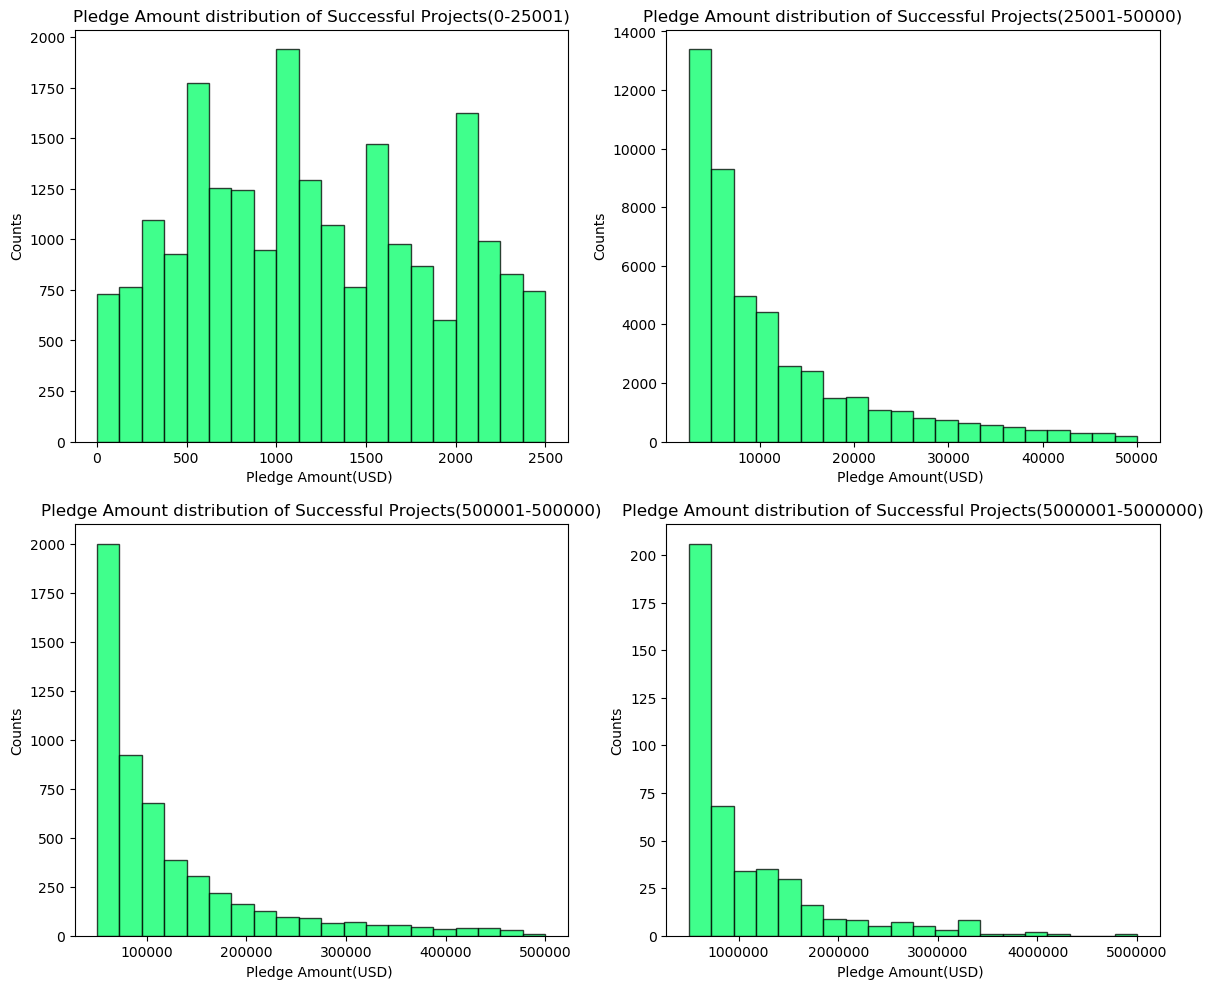

In [30]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Pledge Amount(USD) '
ylabel='Counts'
title = 'Pledge Amount distribution of Successful Projects{}'

ranges =[0,2500]
_=ax[0][0].hist(gdataSuccess.usd_pledged, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-25001)'))

ranges =[2501,50000]
_=ax[0][1].hist(gdataSuccess.usd_pledged, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(25001-50000)'))

ranges =[50001,500000]
_=ax[1][0].hist(gdataSuccess.usd_pledged, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(500001-500000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataSuccess.usd_pledged, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5000001-5000000)'))

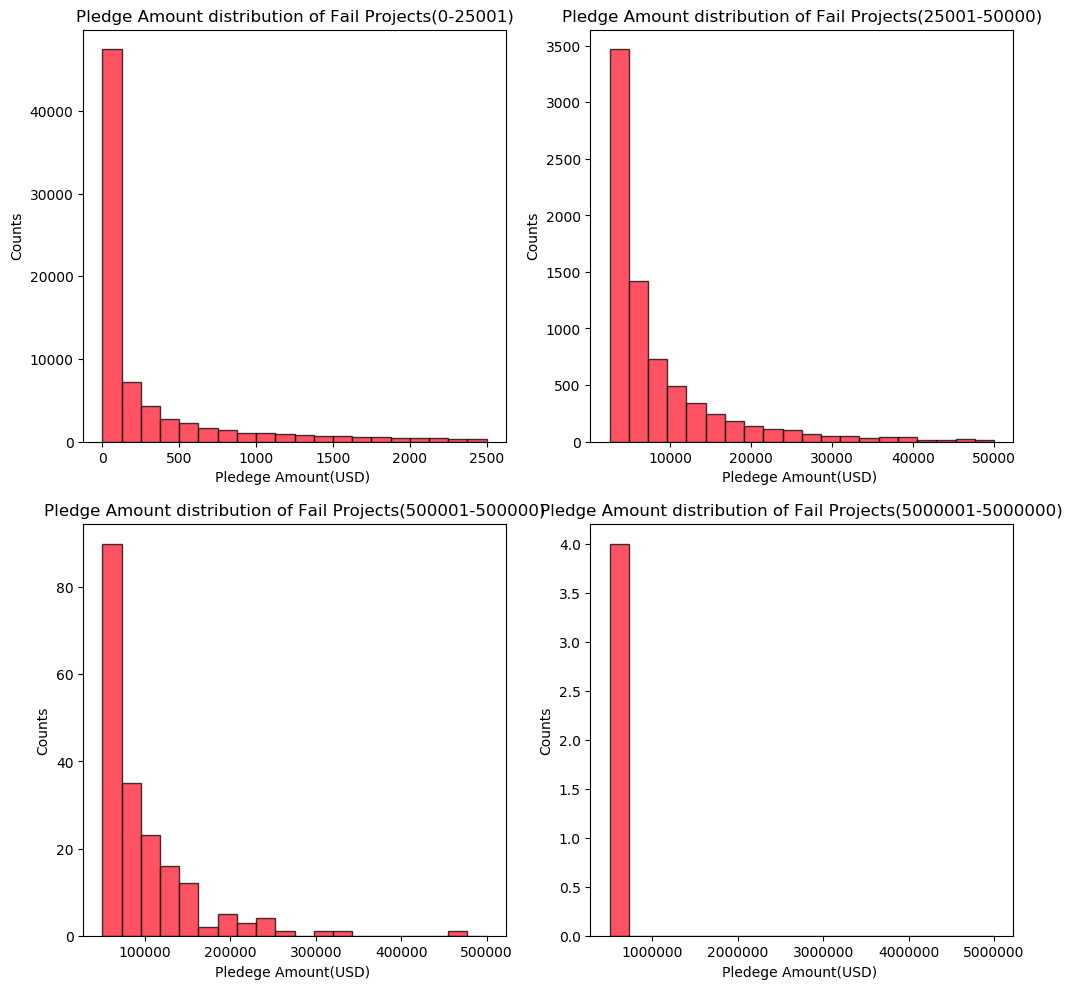

In [31]:
fig, ax = plt.subplots(2,2,figsize=(12,12),dpi=100)
bins=20

xlabel='Pledege Amount(USD) '
ylabel='Counts'
title = 'Pledge Amount distribution of Fail Projects{}'

ranges =[0,2500]
_=ax[0][0].hist(gdataFail.usd_pledged, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-25001)'))

ranges =[2501,50000]
_=ax[0][1].hist(gdataFail.usd_pledged, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(25001-50000)'))

ranges =[50001,500000]
_=ax[1][0].hist(gdataFail.usd_pledged, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(500001-500000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataFail.usd_pledged, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5000001-5000000)'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Is there relationship with pledge amount in success of failure of  project?</h4>
    <ul>
     <li> The average pledge amount of failed project is 25 times lower </li> 
      <li> After pledge amount 2500, the pledge amount and no of succesful have strong negative exponential relationship </li>
       <li> The pledge amount and no of failed also have strong negative exponential relationship </li>
    </ul>
</div>

### Pledge to Goal Ratio

<div class="span5 alert alert-info">
<h4>
Question 5 : Is there relationship with pldege to goal ration in success of failure of  project?</h4>
</div>

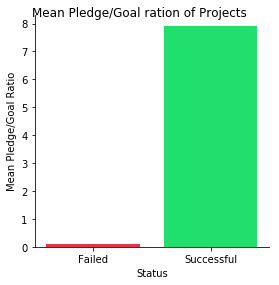

In [32]:
#fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
temp=gdata.loc[:,['pledge_goal_ratio','state']]
temp=temp.groupby('state').mean()
temp['state']=temp.index
#gdata
#temp

xlabel='Status'
ylabel='Mean Pledge/Goal Ratio'
title = 'Mean Pledge/Goal ration of Projects'


g=sns.factorplot(data=temp,x='state',y='pledge_goal_ratio',palette=statuspalette,kind='bar')
_=g.fig.suptitle(title)
_=g.set(xlabel=xlabel, ylabel=ylabel)

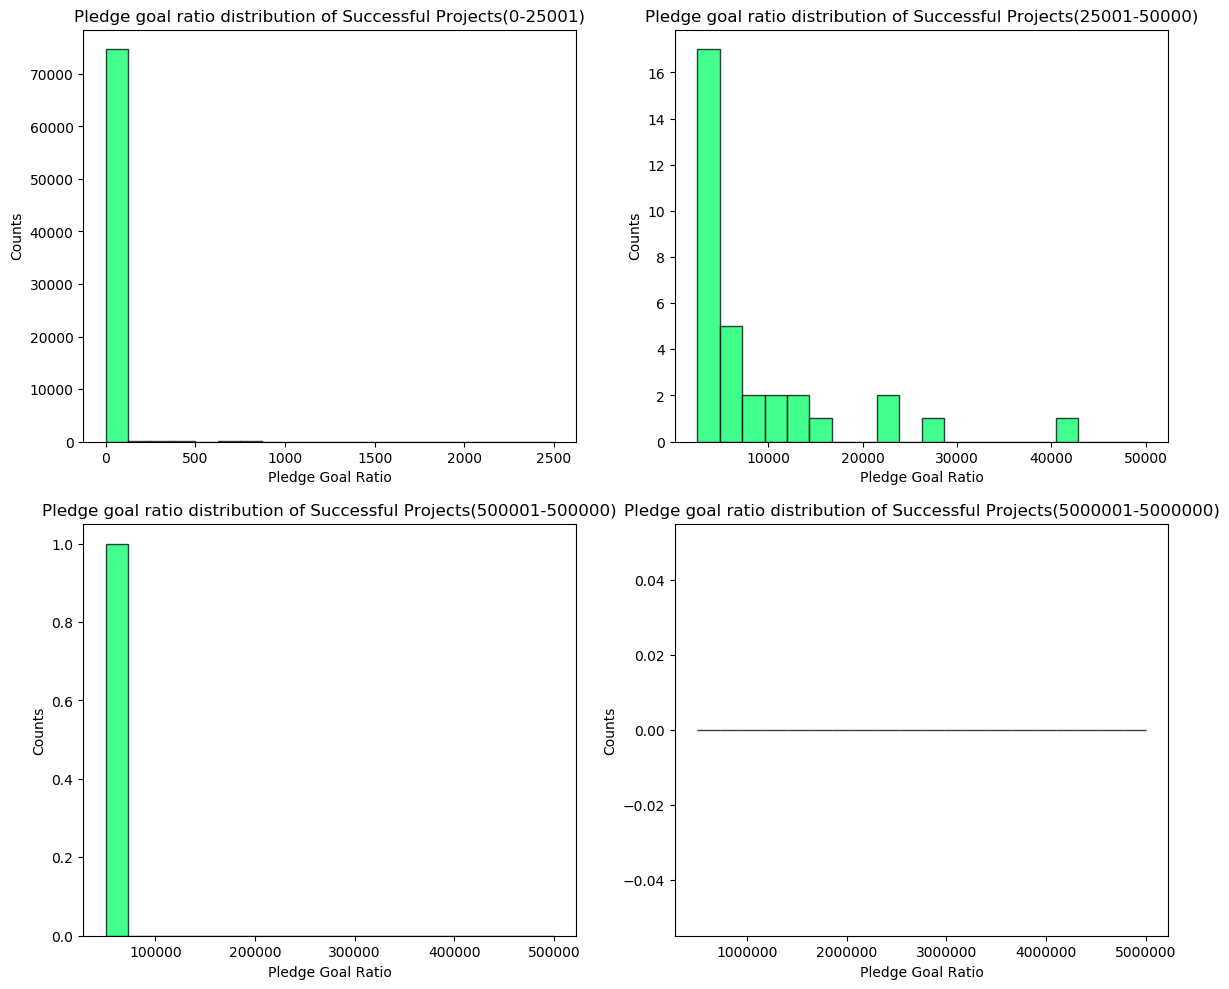

In [33]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Pledge Goal Ratio'
ylabel='Counts'
title = 'Pledge goal ratio distribution of Successful Projects{}'

ranges =[0,2500]
_=ax[0][0].hist(gdataSuccess.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-25001)'))

ranges =[2501,50000]
_=ax[0][1].hist(gdataSuccess.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(25001-50000)'))

ranges =[50001,500000]
_=ax[1][0].hist(gdataSuccess.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(500001-500000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataSuccess.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5000001-5000000)'))

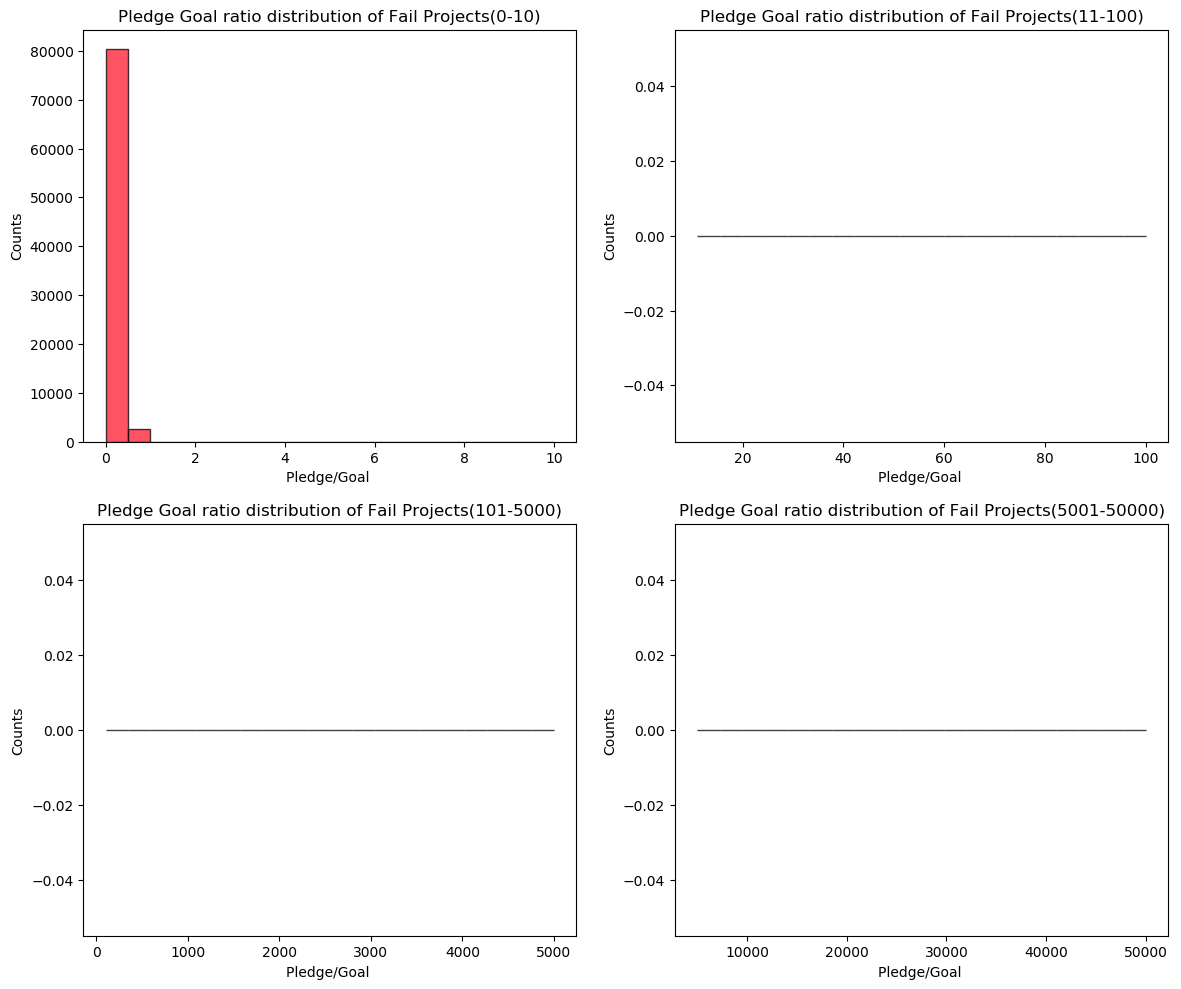

In [34]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Pledge/Goal '
ylabel='Counts'
title = 'Pledge Goal ratio distribution of Fail Projects{}'

ranges =[0,10]
_=ax[0][0].hist(gdataFail.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-10)'))

ranges =[11,100]
_=ax[0][1].hist(gdataFail.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(11-100)'))

ranges =[101,5000]
_=ax[1][0].hist(gdataFail.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(101-5000)'))


ranges =[5001,50000]
_=ax[1][1].hist(gdataFail.pledge_goal_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5001-50000)'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Is there relationship with pldege to goal ration in success of failure of  project?</h4>
    <ul>
     <li> The pledge to goal ratio of succesful project is seven times higher  </li> 
     <li> Most succseful project just achieve there goal amounts. Very rare projects get funding higher then goal amount  </li> 
     <li> Alomst all faied project miss there goal amount by more than 50%. Very rare they fail close to there targeted goal amount. </li> 
    </ul>
</div>

### Pledge to Backers Count Ratio

<div class="span5 alert alert-info">
<h4>
Question 6 : Is there relationship with pldege to no of backers ration in success of failure of  project?</h4>
</div>

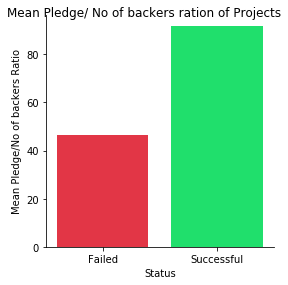

In [35]:
#fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
temp=gdata.loc[:,['pledge_count_ratio','state']]
temp=temp.groupby('state').mean()
temp['state']=temp.index
#gdata
#temp

xlabel='Status'
ylabel='Mean Pledge/No of backers Ratio'
title = 'Mean Pledge/ No of backers ration of Projects'


g=sns.factorplot(data=temp,x='state',y='pledge_count_ratio',palette=statuspalette,kind='bar')
_=g.fig.suptitle(title)
_=g.set(xlabel=xlabel, ylabel=ylabel)

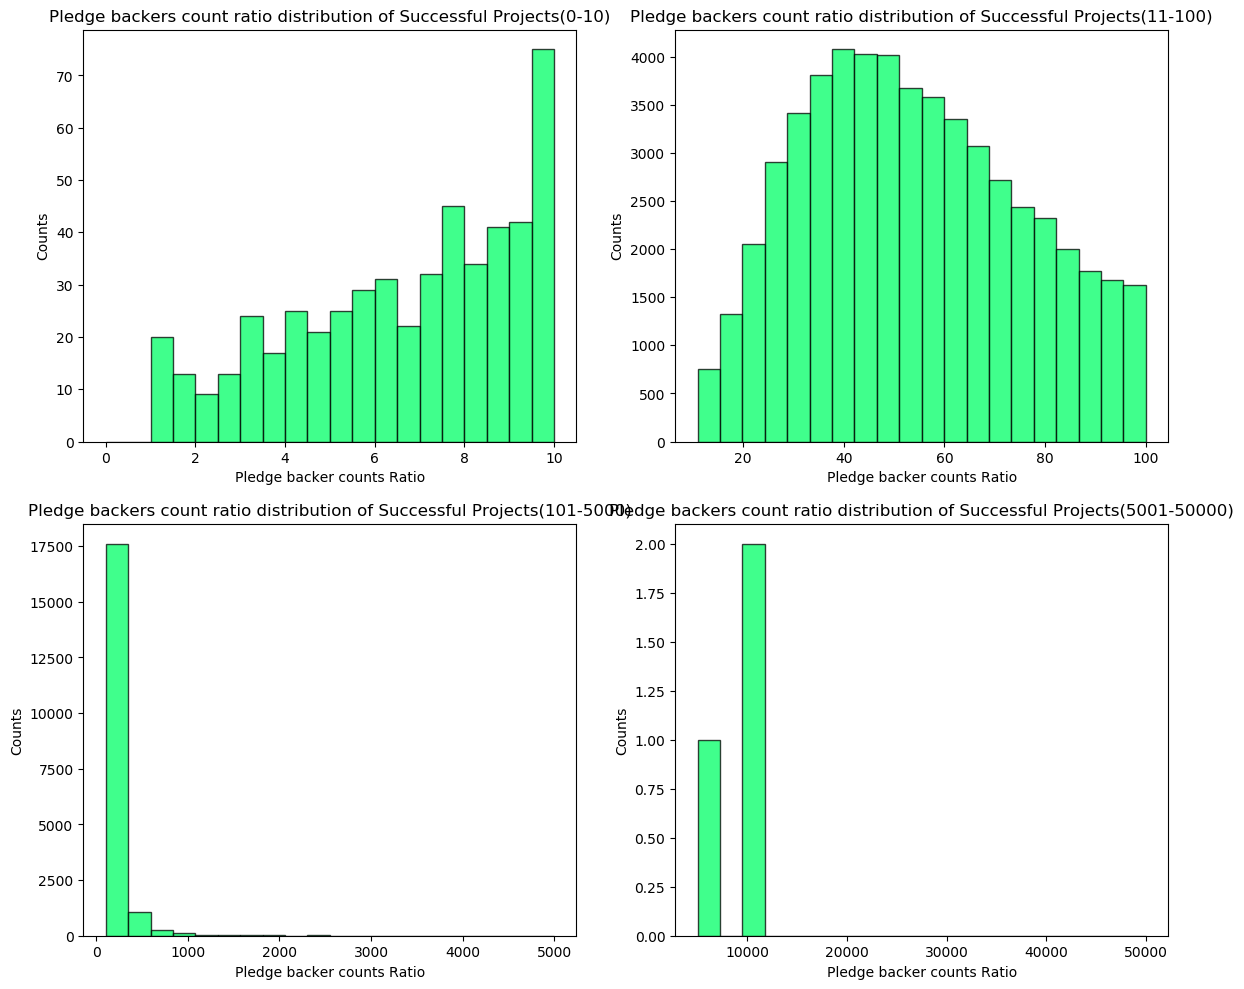

In [36]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Pledge backer counts Ratio'
ylabel='Counts'
title = 'Pledge backers count ratio distribution of Successful Projects{}'

ranges =[0,10]
_=ax[0][0].hist(gdataSuccess.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-10)'))

ranges =[11,100]
_=ax[0][1].hist(gdataSuccess.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(11-100)'))

ranges =[101,5000]
_=ax[1][0].hist(gdataSuccess.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(101-5000)'))


ranges =[5001,50000]
_=ax[1][1].hist(gdataSuccess.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5001-50000)'))

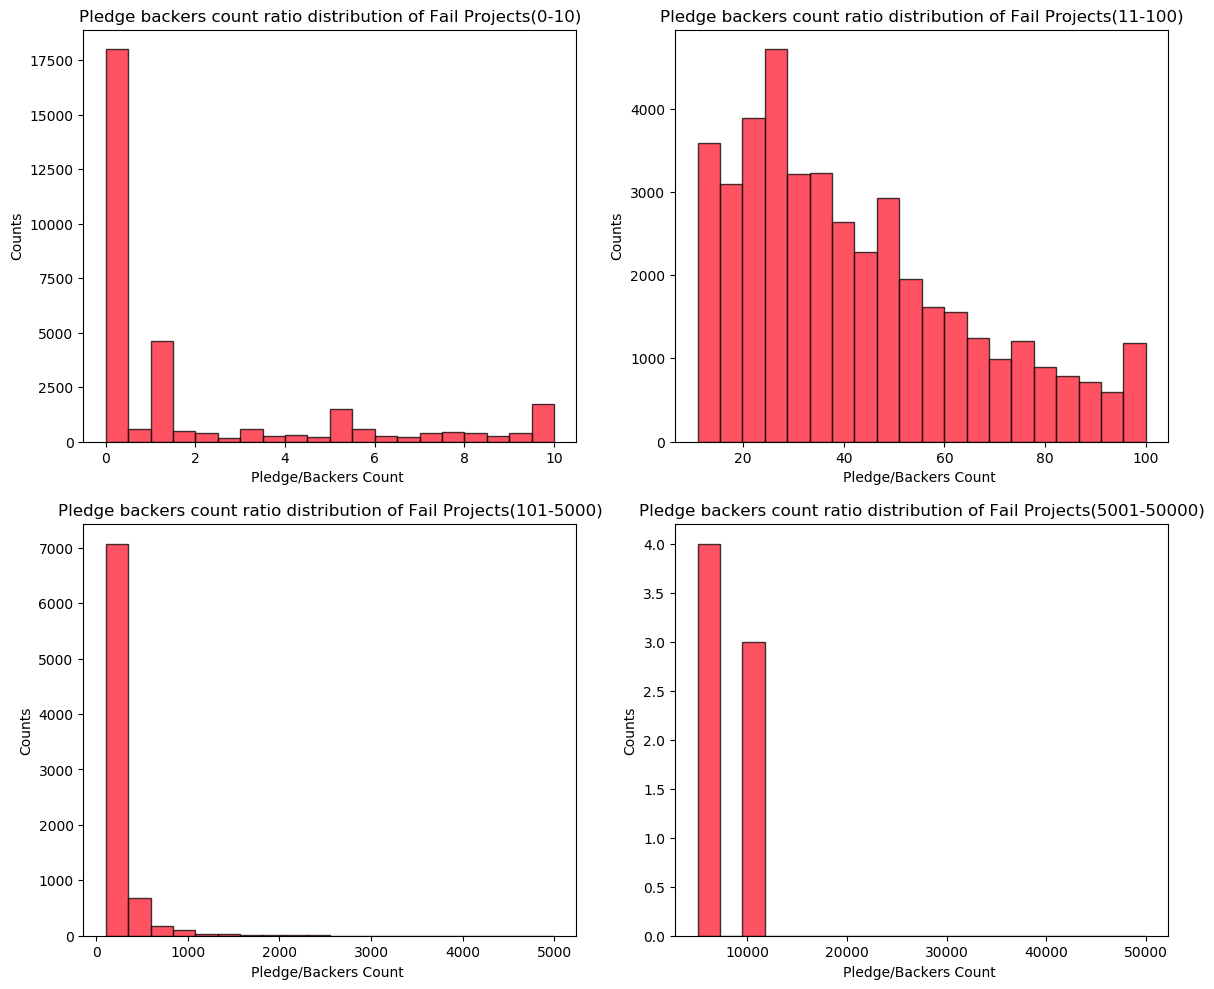

In [37]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='Pledge/Backers Count '
ylabel='Counts'
title = 'Pledge backers count ratio distribution of Fail Projects{}'

ranges =[0,10]
_=ax[0][0].hist(gdataFail.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-10)'))

ranges =[11,100]
_=ax[0][1].hist(gdataFail.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(11-100)'))

ranges =[101,5000]
_=ax[1][0].hist(gdataFail.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(101-5000)'))


ranges =[5001,50000]
_=ax[1][1].hist(gdataFail.pledge_count_ratio, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5001-50000)'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Is there relationship with pldege to no of backers ration in success of failure of  project?</h4>
    <ul>
     <li> The average failed project get 40 per person </li>
     <li> The average successful project gets 90 per person </li>
     <li> The successful project gets mostly 0-100 invested by person .But number increase with amount for successful project</li> 
        <li> The failed project gets mostly 0-100 invested by person .But number decrease with amount for failed project </li> 
     
    </ul>
    </div>

### Backer Count 

<div class="span5 alert alert-info">
<h4>
Question 7 : Is there relationship with no of backers in success of failure of  project?</h4>
</div>


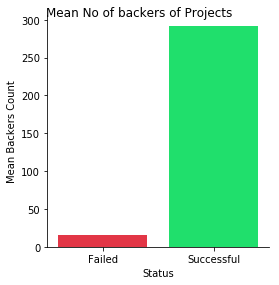

In [38]:
#fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
temp=gdata.loc[:,['backers_count','state']]
temp=temp.groupby('state').mean()
temp['state']=temp.index
#gdata
#temp

xlabel='Status'
ylabel='Mean Backers Count'
title = 'Mean No of backers of Projects'


g=sns.factorplot(data=temp,x='state',y='backers_count',palette=statuspalette,kind='bar')
_=g.fig.suptitle(title)
_=g.set(xlabel=xlabel, ylabel=ylabel)

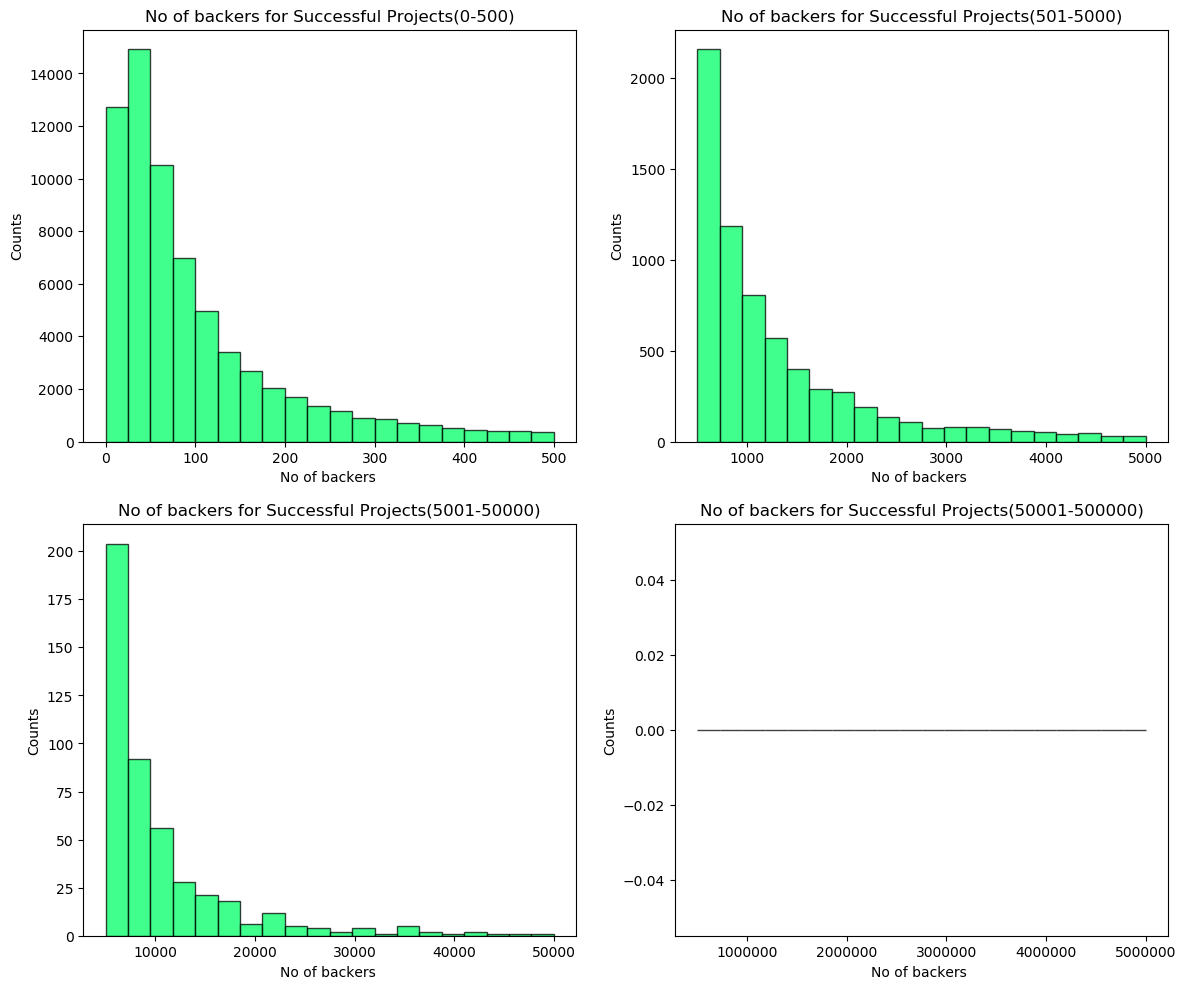

In [39]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='No of backers '
ylabel='Counts'
title = 'No of backers for Successful Projects{}'

ranges =[0,500]
_=ax[0][0].hist(gdataSuccess.backers_count, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-500)'))

ranges =[501,5000]
_=ax[0][1].hist(gdataSuccess.backers_count, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(501-5000)'))

ranges =[5001,50000]
_=ax[1][0].hist(gdataSuccess.backers_count, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(5001-50000)'))


ranges =[500001,5000000]
_=ax[1][1].hist(gdataSuccess.backers_count, bins,  histtype='bar',range=ranges, color=color_success, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(50001-500000)'))

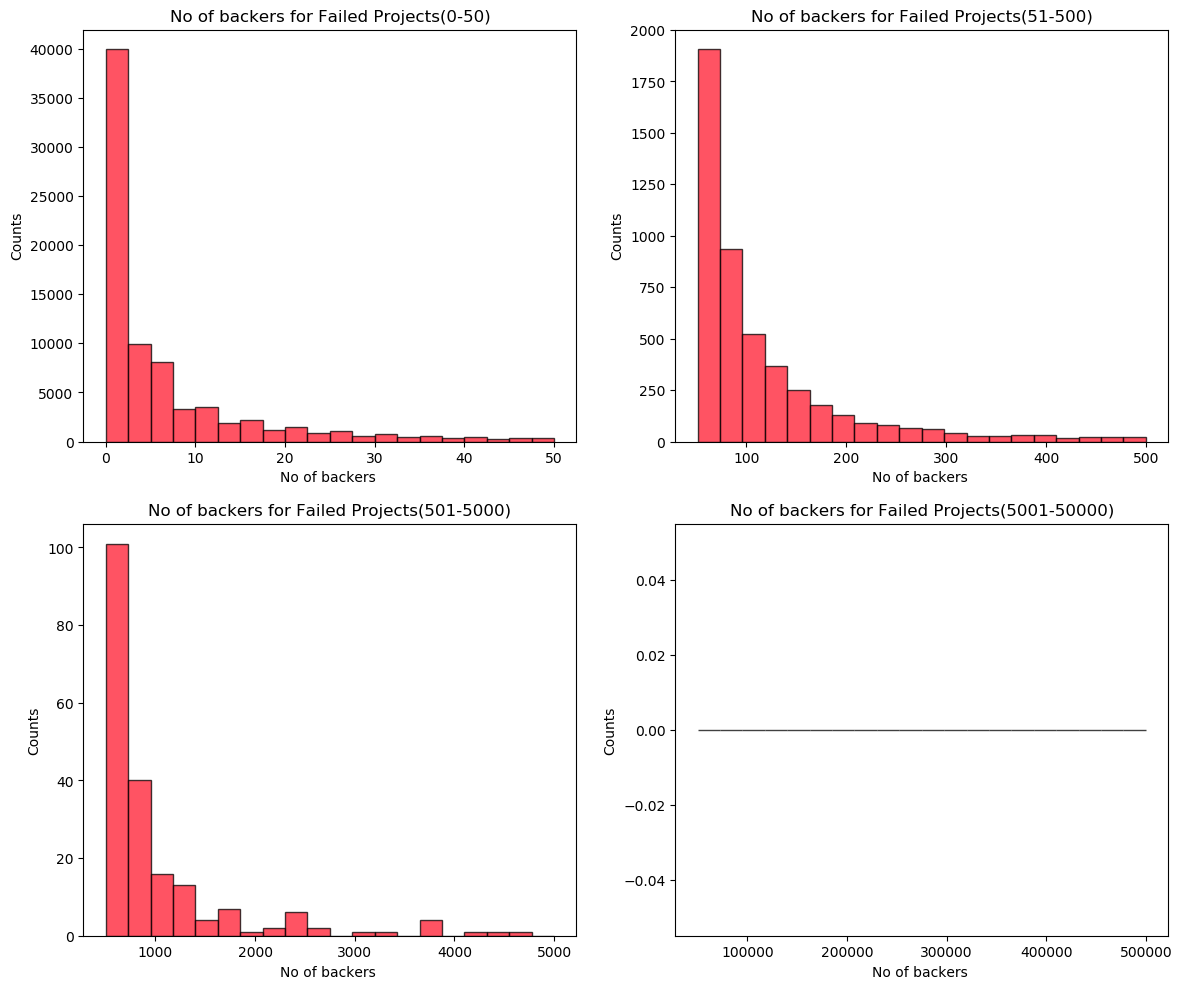

In [40]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=100)
bins=20

xlabel='No of backers '
ylabel='Counts'
title = 'No of backers for Failed Projects{}'

ranges =[0,50]
_=ax[0][0].hist(gdataFail.backers_count, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')

_=ax[0][0].set_ylabel(ylabel)
_=ax[0][0].set_xlabel(xlabel)
_=ax[0][0].set_title(title.format('(0-50)'))

ranges =[51,500]
_=ax[0][1].hist(gdataFail.backers_count, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[0][1].set_ylabel(ylabel)
_=ax[0][1].set_xlabel(xlabel)
_=ax[0][1].set_title(title.format('(51-500)'))

ranges =[501,5000]
_=ax[1][0].hist(gdataFail.backers_count, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][0].set_ylabel(ylabel)
_=ax[1][0].set_xlabel(xlabel)
_=ax[1][0].set_title(title.format('(501-5000)'))


ranges =[50001,500000]
_=ax[1][1].hist(gdataFail.backers_count, bins,  histtype='bar',range=ranges, color=color_fail, alpha=0.75, ec='black')
_=ax[1][1].set_ylabel(ylabel)
_=ax[1][1].set_xlabel(xlabel)
_=ax[1][1].set_title(title.format('(5001-50000)'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Is there relationship with no of backers in success of failure of  project?</h4>
    <ul>
     <li> The averagenumber of backers of succesful project is two hundred eighty times higher  </li> 
     <li> Number of backers and count of succesful have strong negative exponential relationship   </li> 
     <li> Most failed project has only 2 backers.  </li> 
    
    </ul>
</div>

### country 

<div class="span5 alert alert-info">
<h4>
Question 8 : Which country are having most and least successful or failed project?</h4>
</div>

In [41]:
analyzecol='country'
gdata=df_fail_success.loc[:,[analyzecol , 'state','project_id']]

gdata_success_top=extratDataFrameByGroup(gdata,stateSuccess,analyzecol,True,10,'state')
gdata_success_bottom=extratDataFrameByGroup(gdata,stateSuccess,analyzecol,False,10,'state')

gdata_fail_top=extratDataFrameByGroup(gdata,stateFail,analyzecol,True,10,'state')
gdata_fail_bottom=extratDataFrameByGroup(gdata,stateFail,analyzecol,False,10,'state')

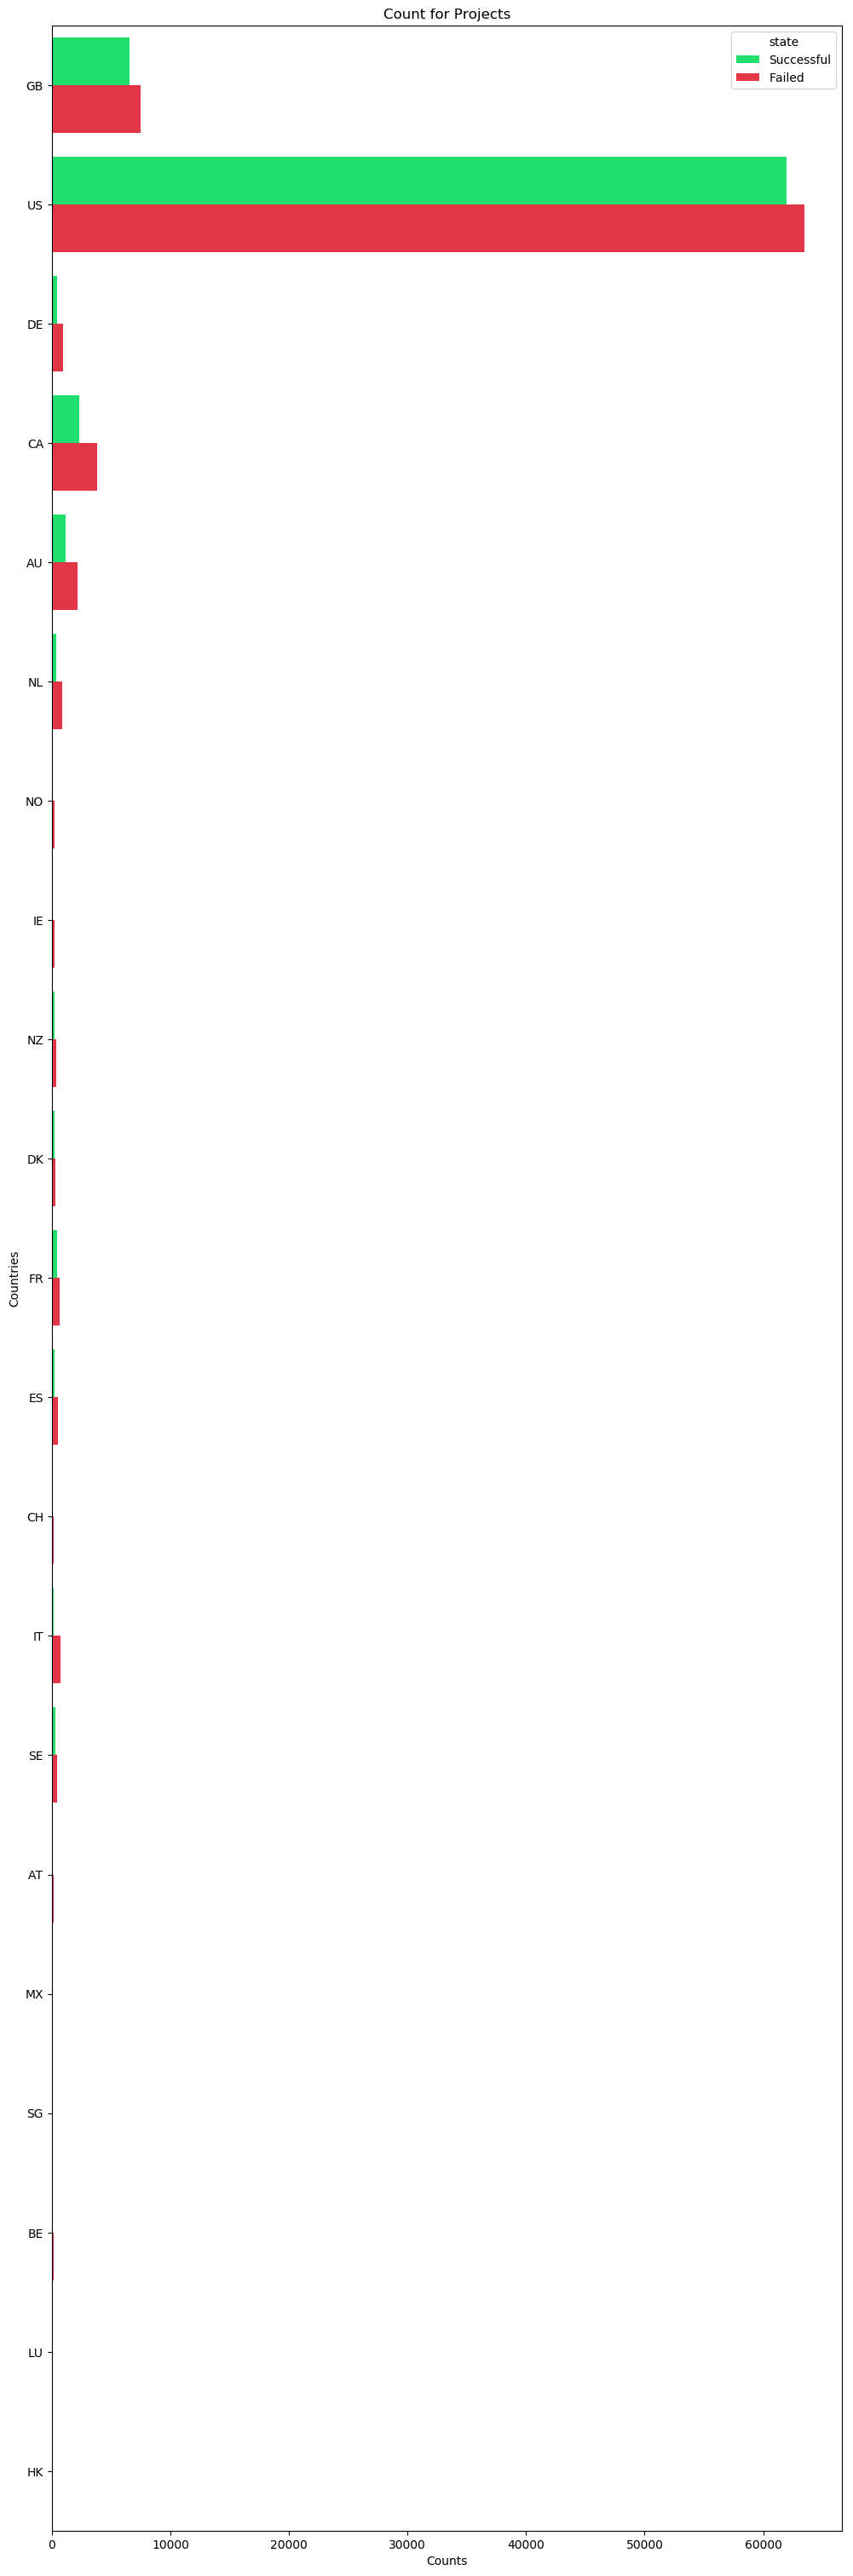

In [42]:
fig, axis = plt.subplots(1,1,figsize=(10,30),dpi=100)
fig.tight_layout()
graph_color_palette=[
    color_success,#kickstarter green#'#2BDE73'
    color_fail, # red
]


axis=sns.countplot(data=gdata,y=analyzecol,palette=graph_color_palette,hue='state')
xlabel='Counts'
ylabel='Countries'
title = 'Count for Projects'
#_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_title(title)

#for p in axis.patches:
        #_=axis.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

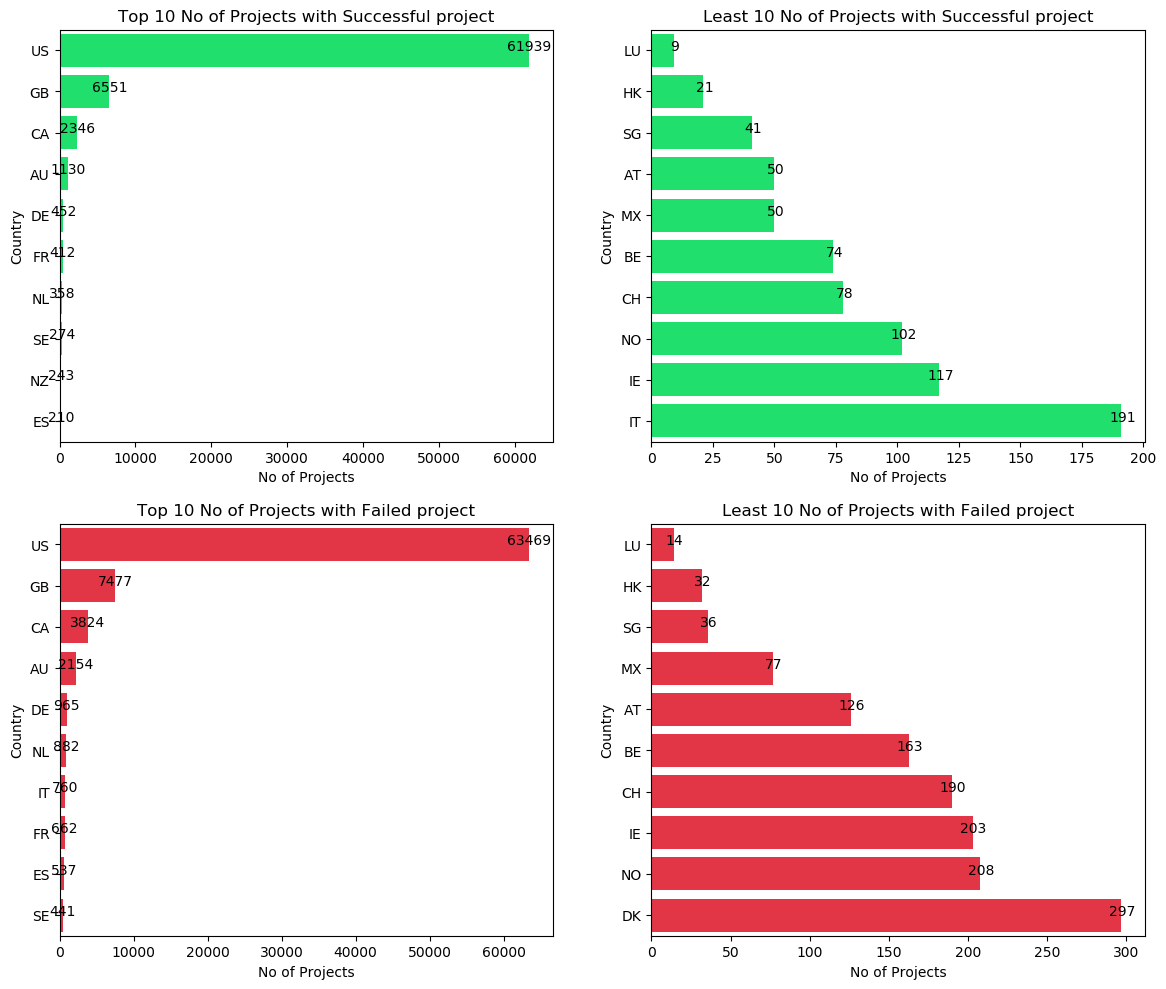

In [43]:
fig, axis = plt.subplots(2,2,figsize=(14,12),dpi=100)
ylabel='Country'
xlabel='No of Projects'
label = '{} 10 {} with {} project'
axis[0][0]=drawbarplot(gdata_success_top,analyzecol,'state',color_success,axis[0][0],ylabel,xlabel,label.format('Top',xlabel,'Successful')) 
axis[0][1]=drawbarplot(gdata_success_bottom,analyzecol,'state',color_success,axis[0][1],ylabel,xlabel,label.format('Least',xlabel,'Successful')) 

axis[1][0]=drawbarplot(gdata_fail_top,analyzecol,'state',color_fail,axis[1][0],ylabel,xlabel,label.format('Top',xlabel,'Failed')) 
axis[1][1]=drawbarplot(gdata_fail_bottom,analyzecol,'state',color_fail,axis[1][1],ylabel,xlabel,label.format('Least',xlabel,'Failed'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Which country are having most and least successful or failed project?</h4>
    <ul>
     <li> Most project belongs to United States in bith Success and Failed Status. </li> 
     <li> Most countries in Top 10 and bottom 10 are same. It means these are most and least particpating countries </li> 
     <li> The ratio of successful and failed project for particular country is approximately similar</li> 
    </ul>
</div>

### staff pick 

<div class="span5 alert alert-info">
<h4>
Question 9 : Does staff pick maked more successful projects?</h4>
</div>

In [44]:
analyzecol='staff_pick'

gdata=df_fail_success.loc[:,[analyzecol , 'state','project_id']]

gdata_success=gdata[gdata.state==stateSuccess]
gdata_fail=gdata[gdata.state==stateFail]

gdataSuccess=gdata[gdata.state==stateSuccess]
gdataSuccess=gdataSuccess.groupby([analyzecol]).count()
gdataSuccess=gdataSuccess.reset_index()

gdataFail=gdata[gdata.state==stateFail]
gdataFail=gdataFail.groupby([analyzecol]).count()
gdataFail=gdataFail.reset_index()

In [45]:
# make data frame for percentage 
ysuccess=gdataSuccess.groupby(analyzecol).sum()
yFail=gdataFail.groupby(analyzecol).sum()

_=ysuccess.rename(columns={'state': 'state_success'}, inplace=True)
_=yFail.rename(columns={'state': 'state_fail'}, inplace=True)
result = pd.concat([ysuccess, yFail], axis=1)

result=result.assign(
    success_ratio=lambda row:convertToPercentage( calculate_ratio((row.state_success),(row.state_success+row.state_fail))))

result=result.assign(
    fail_ratio=lambda row: convertToPercentage(calculate_ratio((row.state_fail),(row.state_success+row.state_fail))))

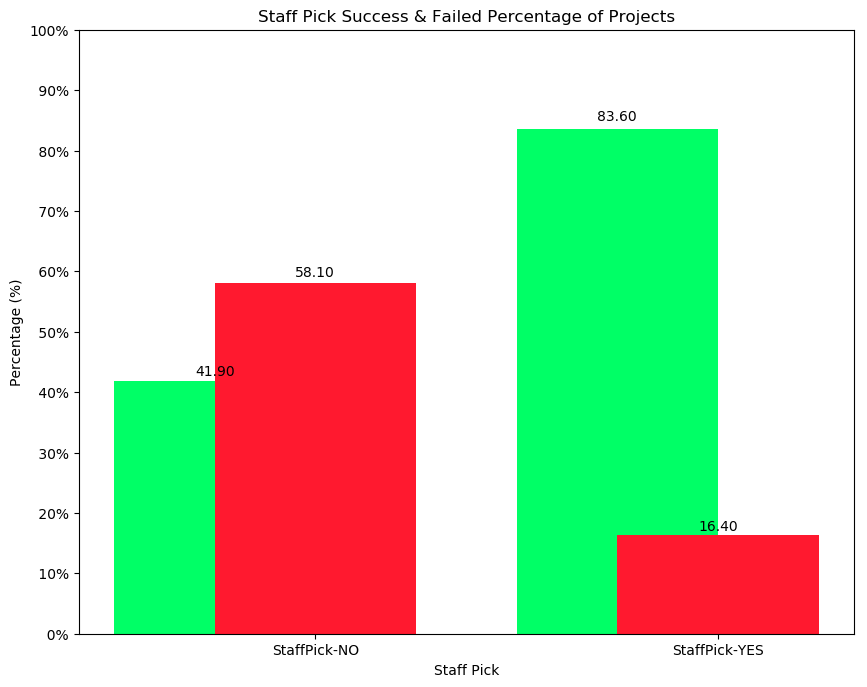

In [46]:
width = 0.50       # the width of the bars

ind = np.arange(2)

fig, ax = plt.subplots(1,1,figsize=(10,8),dpi=100)
rects1 = ax.bar(ind, result.success_ratio, width, color=color_success)#, yerr=men_std)
rects2 = ax.bar(ind + width/2, result.fail_ratio, width, color=color_fail)#, yerr=women_std)

xlist=('StaffPick-NO','StaffPick-YES')
# add some text for labels, title and axes ticks
_=ax.set_xticks(ind + width / 2)
_=ax.set_xticklabels(xlist)

perc = np.arange(0, 101, 10)

_=ax.set_yticks(perc)
_=ax.set_yticklabels(['{:3.0f}%'.format(x) for x in  perc])

autolabel(rects1,'%0.2f')
autolabel(rects2,'%0.2f')

xlabel='Staff Pick'
ylabel='Percentage (%)'
title = 'Staff Pick Success & Failed Percentage of Projects'

_=ax.set_ylabel(ylabel)
_=ax.set_xlabel(xlabel)
_=ax.set_title(title)

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : Does staff pick maked more successful projects? ?</h4>
    <ul>
     <li> When project is not staff pick the ratio of success and failed project is close </li> 
     <li> When project is staff pick the ratio of success is five times higher than failed project</li> 
    </ul>
</div>


<div class="span5 alert alert-info">
<h4>
Question 10 : What categories are having most and least successful or failed project?</h4>
</div>

In [47]:
#fig, axis = plt.subplots(1,1,figsize=(20,12),dpi=100)
gdata=df_fail_success[['category' , 'state','project_id']]#.groupby(['category' , 'state']).count().unstack()#[0:1000
gdata_success=gdata[gdata.state==stateSuccess]
gdata_fail=gdata[gdata.state==stateFail]

#gdata_success[gdata_success.category=='Gadgets'].count()
#gdata_fail[gdata_fail.category=='Gadgets'].count()

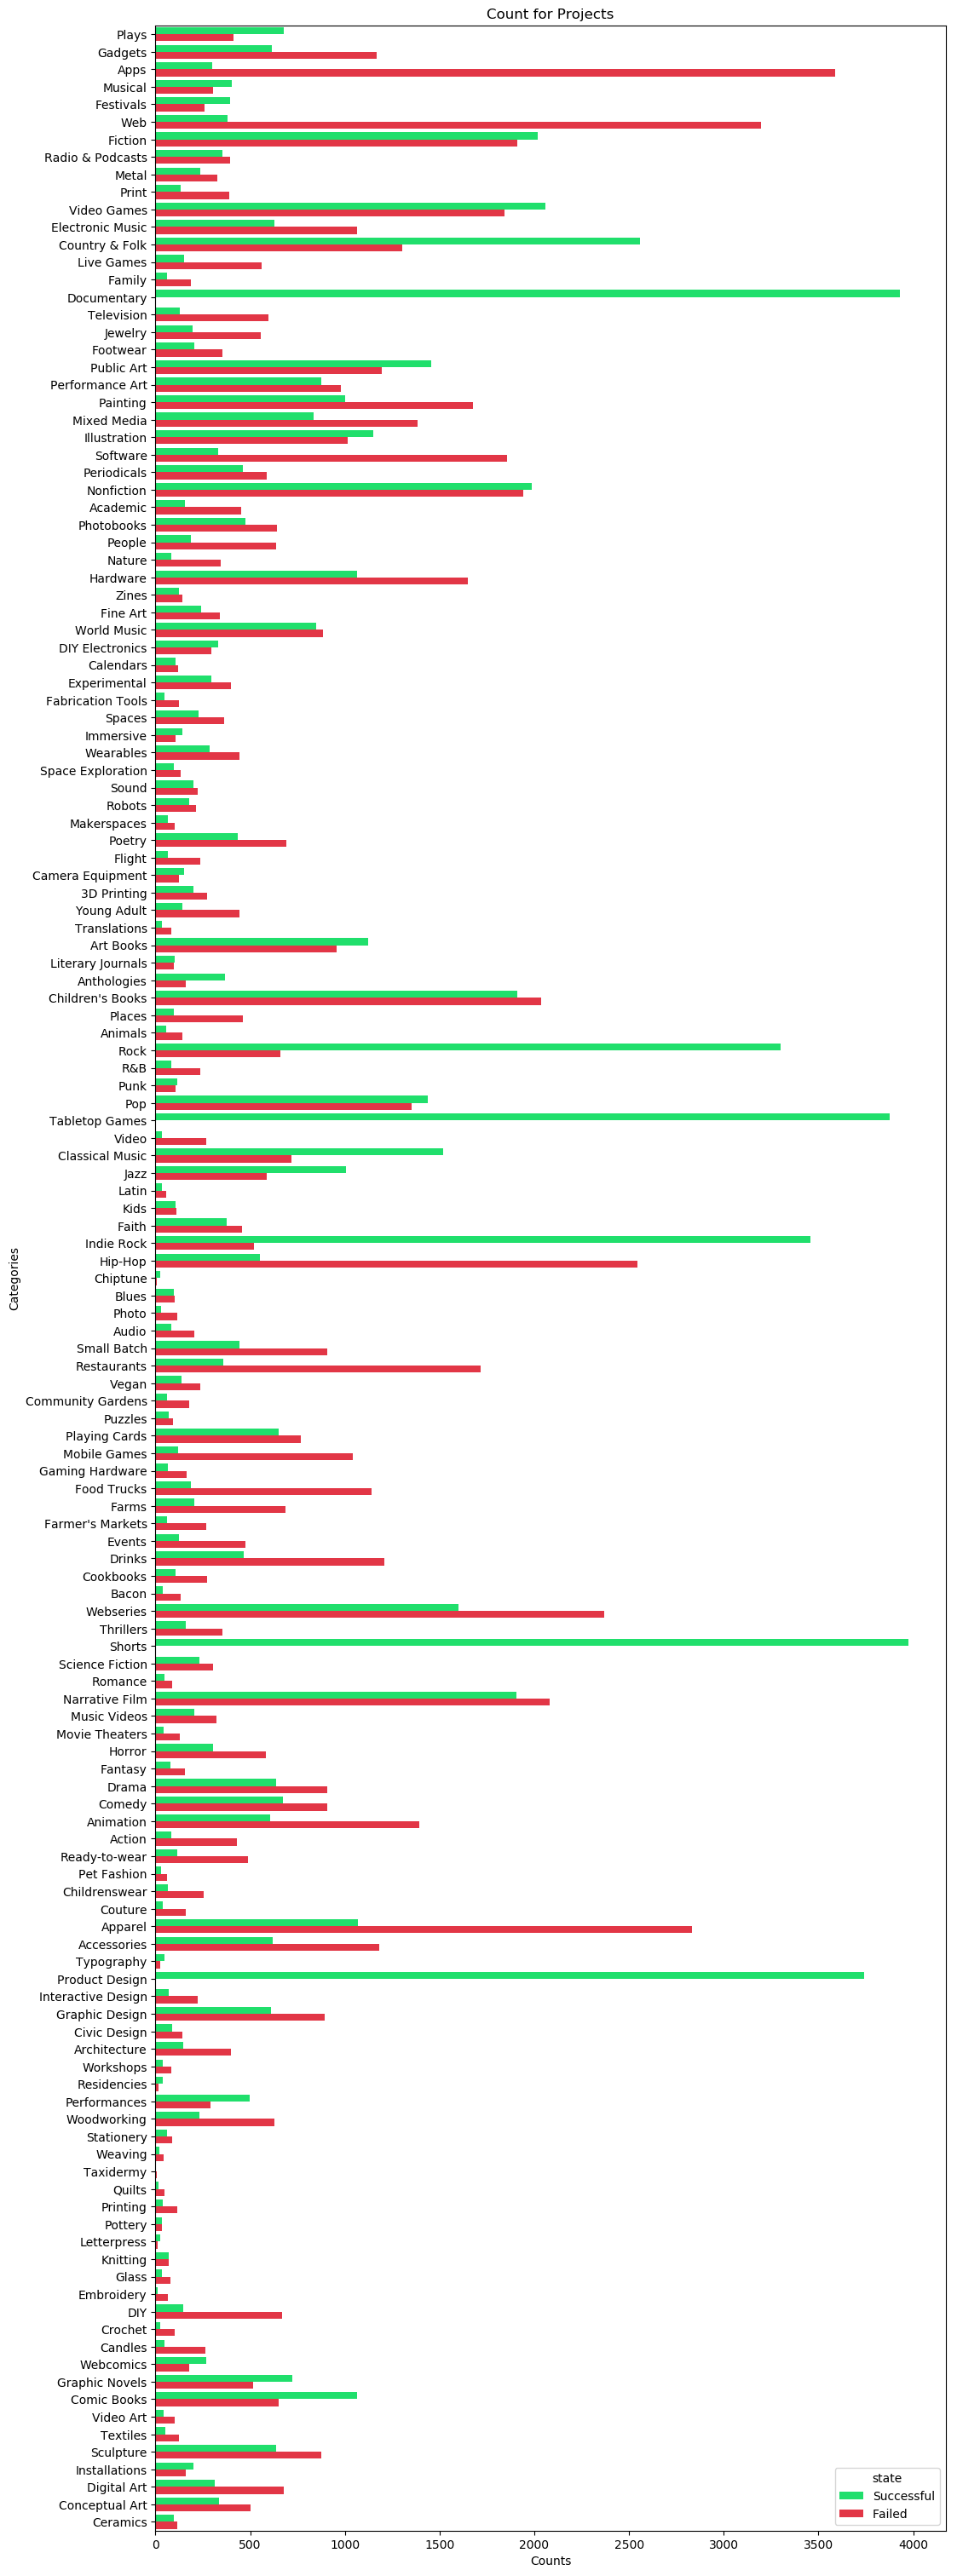

In [48]:
fig, axis = plt.subplots(1,1,figsize=(10,30),dpi=100)
fig.tight_layout()
graph_color_palette=[
    color_success,#kickstarter green#'#2BDE73'
    color_fail, # red
]
analyzecol='category'

axis=sns.countplot(data=gdata,y=analyzecol,palette=graph_color_palette,hue='state')
xlabel='Counts'
ylabel='Categories'
title = 'Count for Projects'
#_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_title(title)

#for p in axis.patches:
        #_=axis.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [49]:
#gdata.category.unique()
gdata_success_top=gdata[gdata.state==stateSuccess].groupby(['category']).count().nlargest(10,'state').reset_index()
gdata_success_bottom=gdata[gdata.state==stateSuccess].groupby(['category']).count().nsmallest(10,'state').reset_index()

gdata_fail_top=gdata[gdata.state==stateFail].groupby(['category']).count().nlargest(10,'state').reset_index()
gdata_fail_bottom=gdata[gdata.state==stateFail].groupby(['category']).count().nsmallest(10,'state').reset_index()

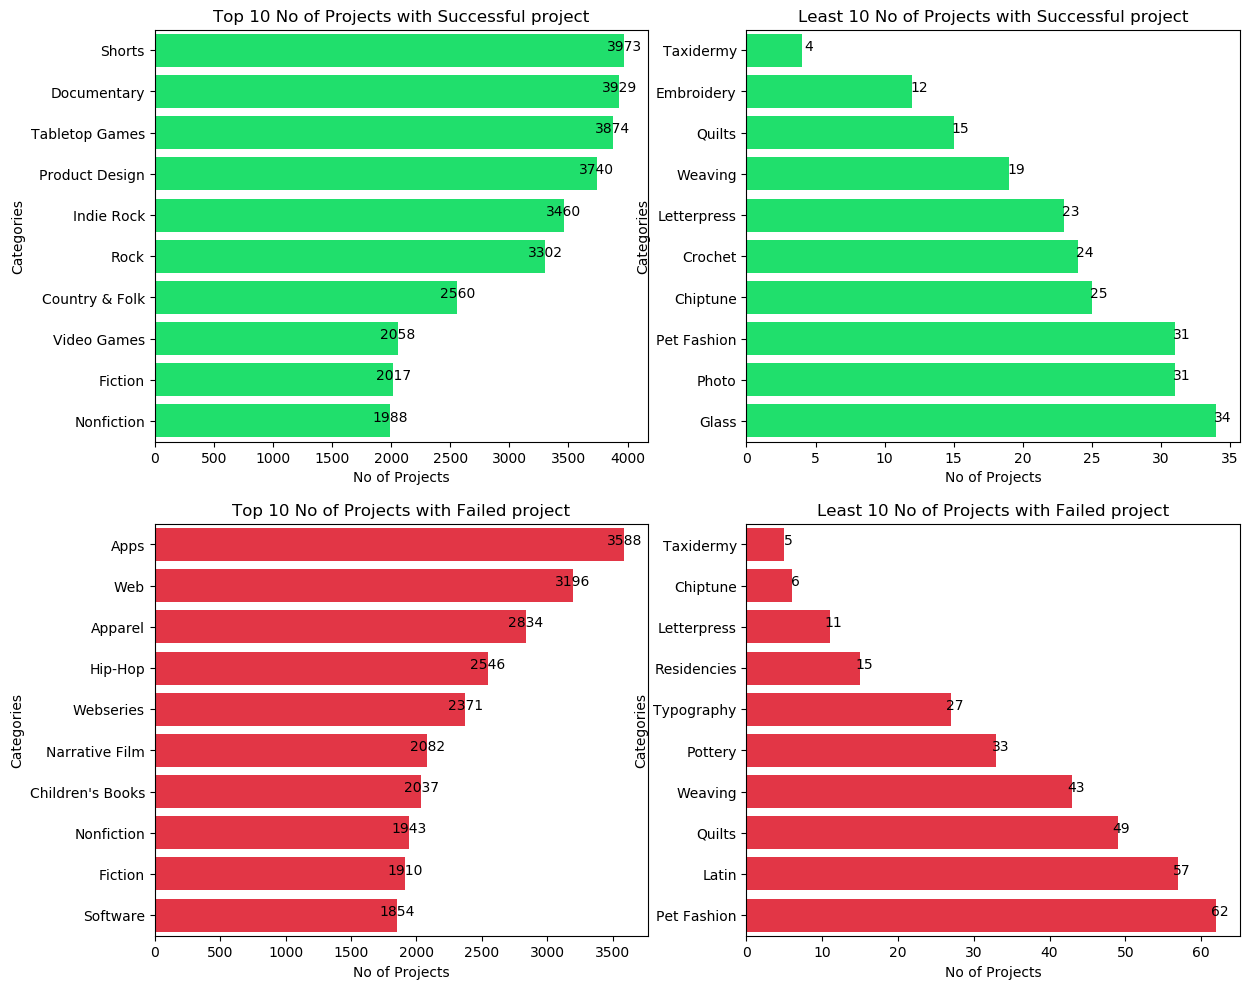

In [50]:
fig, axis = plt.subplots(2,2,figsize=(14,12),dpi=100)

ylabel='Categories'
xlabel='No of Projects'
label = '{} 10 {} with {} project'

axis[0][0]=drawbarplot(gdata_success_top,analyzecol,'state',color_success,axis[0][0],ylabel,xlabel,label.format('Top',xlabel,'Successful')) 
axis[0][1]=drawbarplot(gdata_success_bottom,analyzecol,'state',color_success,axis[0][1],ylabel,xlabel,label.format('Least',xlabel,'Successful')) 

axis[1][0]=drawbarplot(gdata_fail_top,analyzecol,'state',color_fail,axis[1][0],ylabel,xlabel,label.format('Top',xlabel,'Failed')) 
axis[1][1]=drawbarplot(gdata_fail_bottom,analyzecol,'state',color_fail,axis[1][1],ylabel,xlabel,label.format('Least',xlabel,'Failed'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion :  What categories are having most and least successful or failed project?</h4>
    <ul>
     <li>Some category like Apps and Webs have high failing ratio. </li> 
     <li> Some category like product desgin and shorts have high success ratio. </li> 
     <li> No Top 10 or bottom 10 categories are common, whic means categories have impact of state </li> 
    </ul>
</div>

### Location Type 

<div class="span5 alert alert-info">
<h4>
Question 11 : What location type are having most and least successful or failed project?</h4>
</div>

In [51]:
analyzecol='location_type'
gdata=df_fail_success.loc[:,[analyzecol , 'state','project_id']]

gdata_success_top=extratDataFrameByGroup(gdata,stateSuccess,analyzecol,True,10,'state')
gdata_success_bottom=extratDataFrameByGroup(gdata,stateSuccess,analyzecol,False,10,'state')

gdata_fail_top=extratDataFrameByGroup(gdata,stateFail,analyzecol,True,10,'state')
gdata_fail_bottom=extratDataFrameByGroup(gdata,stateFail,analyzecol,False,10,'state')

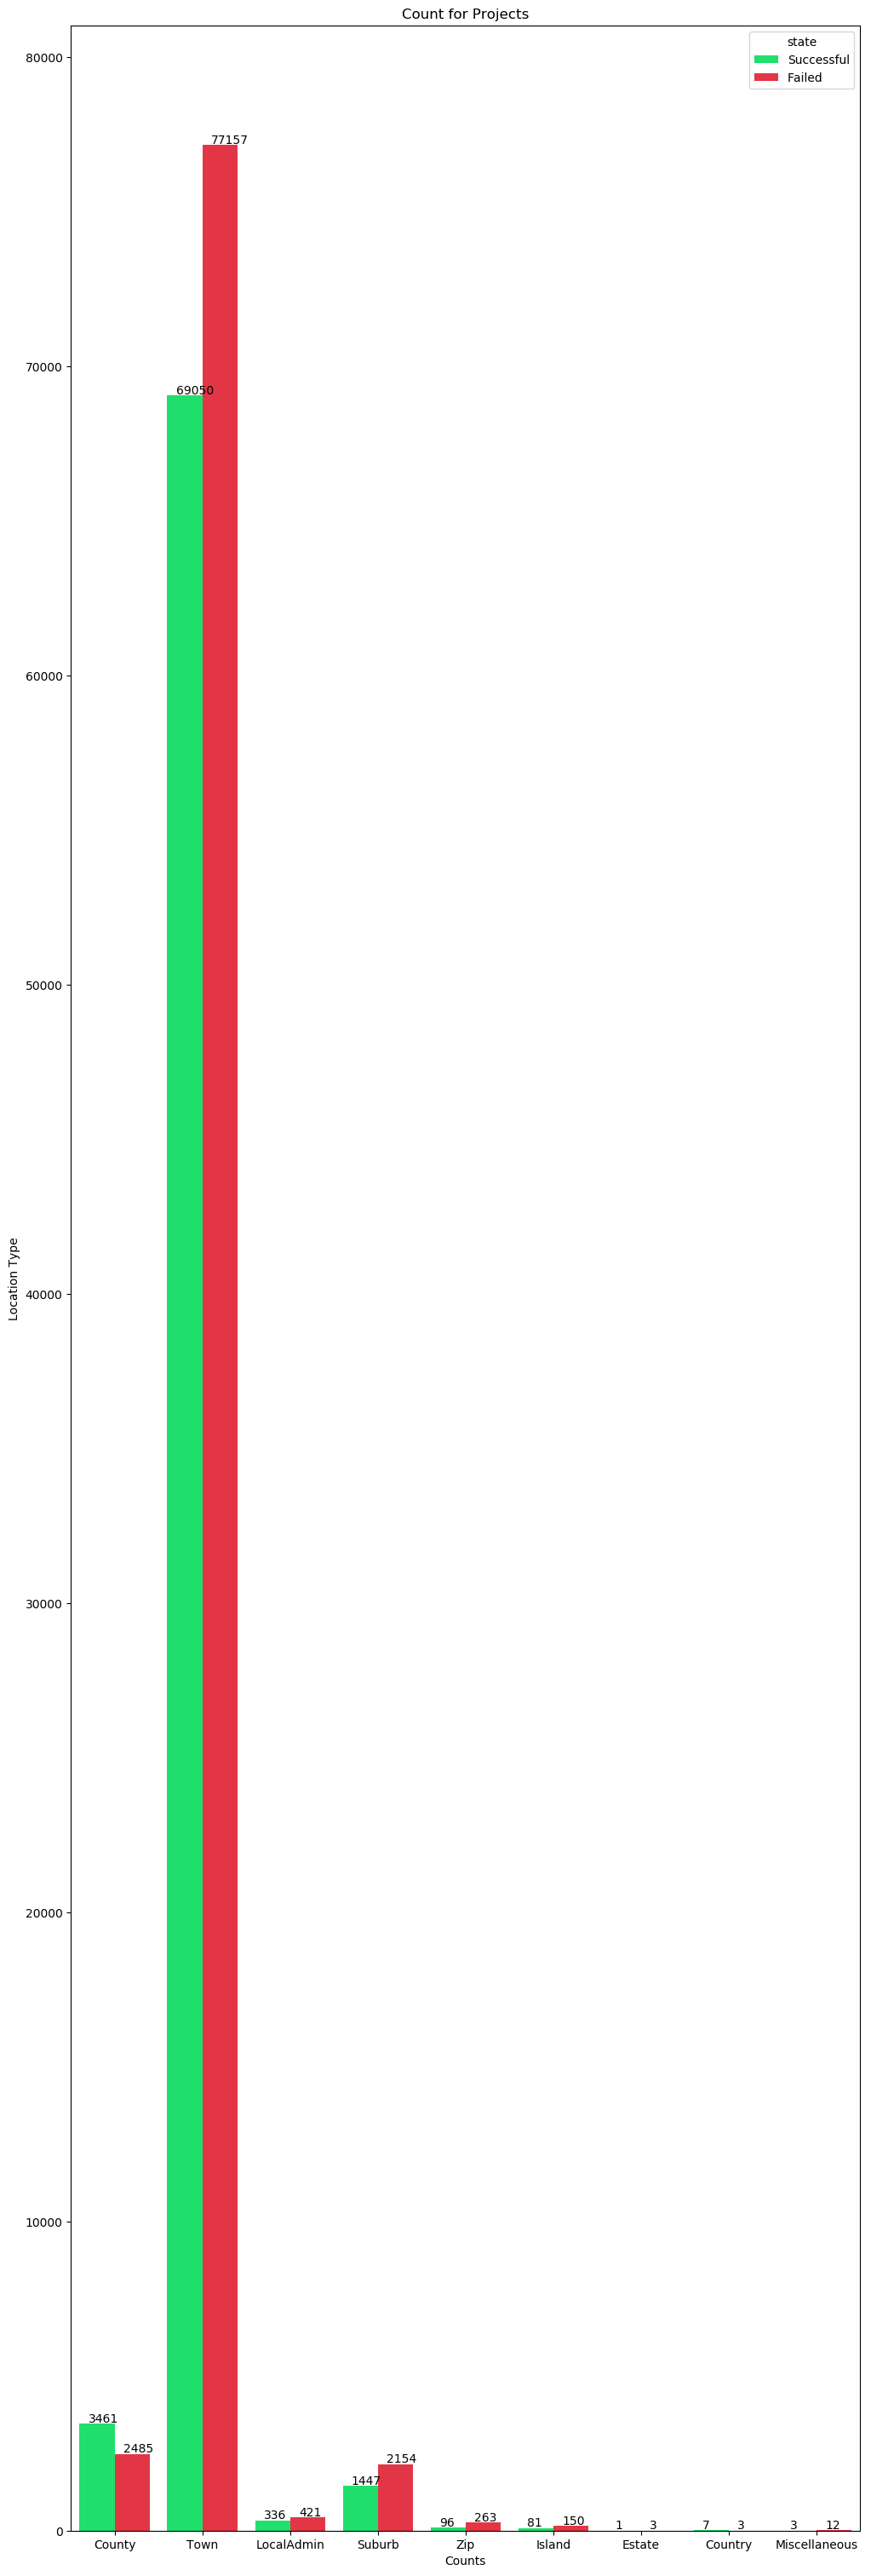

In [52]:
fig, axis = plt.subplots(1,1,figsize=(10,30),dpi=100)
fig.tight_layout()
graph_color_palette=[
    color_success,#kickstarter green#'#2BDE73'
    color_fail, # red
]


axis=sns.countplot(data=gdata,x=analyzecol,palette=graph_color_palette,hue='state')
xlabel='Counts'
ylabel='Location Type'
title = 'Count for Projects'
#_=plt.figure(figsize=(10,6))
_=axis.set_ylabel(ylabel)
_=axis.set_xlabel(xlabel)
_=axis.set_title(title)

for p in axis.patches:
        _=axis.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

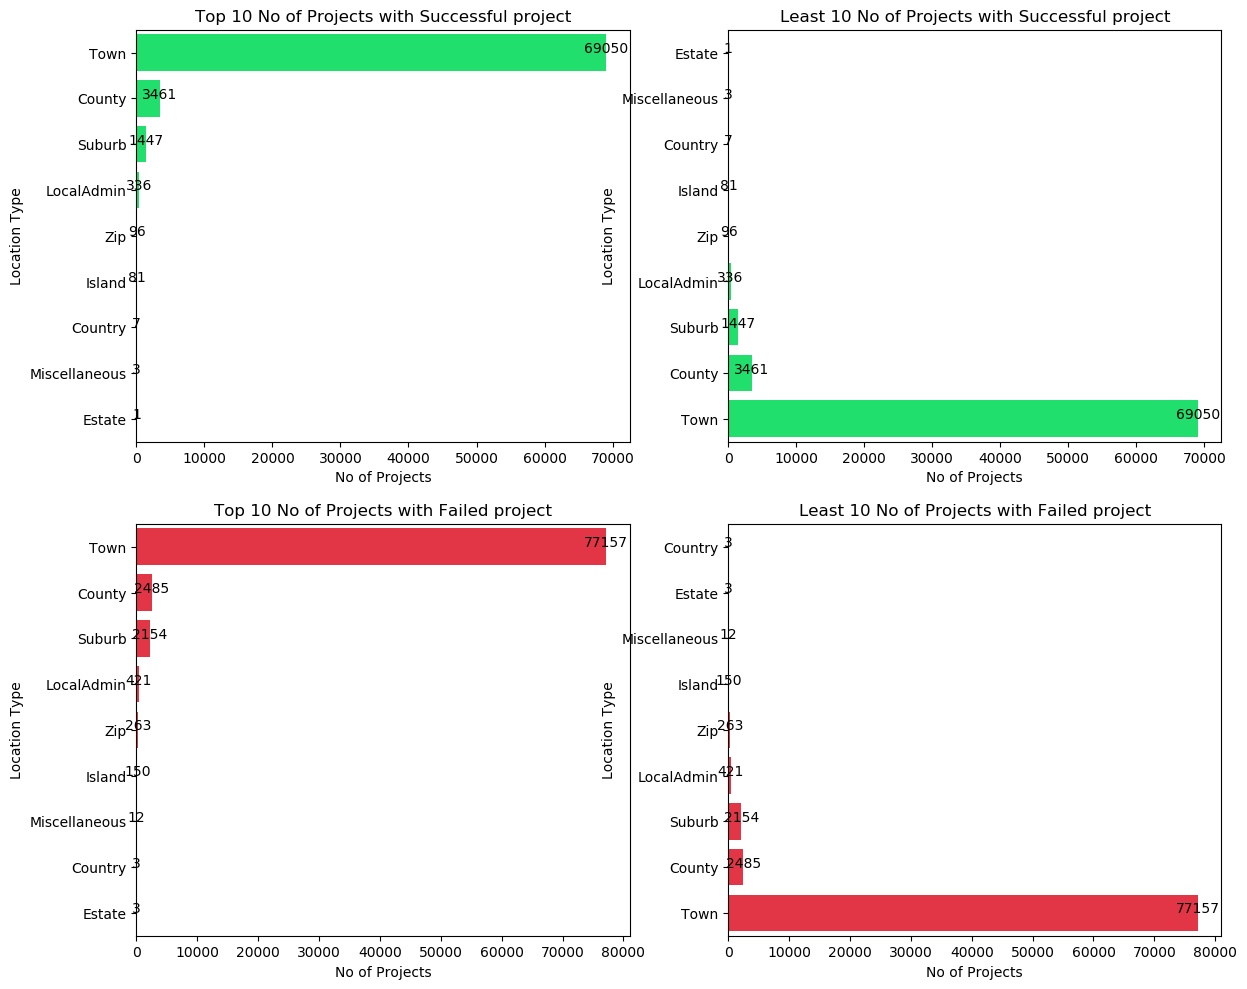

In [53]:
fig, axis = plt.subplots(2,2,figsize=(14,12),dpi=100)
ylabel='Location Type'
xlabel='No of Projects'
label = '{} 10 {} with {} project'
axis[0][0]=drawbarplot(gdata_success_top,analyzecol,'state',color_success,axis[0][0],ylabel,xlabel,label.format('Top',xlabel,'Successful')) 
axis[0][1]=drawbarplot(gdata_success_bottom,analyzecol,'state',color_success,axis[0][1],ylabel,xlabel,label.format('Least',xlabel,'Successful')) 

axis[1][0]=drawbarplot(gdata_fail_top,analyzecol,'state',color_fail,axis[1][0],ylabel,xlabel,label.format('Top',xlabel,'Failed')) 
axis[1][1]=drawbarplot(gdata_fail_bottom,analyzecol,'state',color_fail,axis[1][1],ylabel,xlabel,label.format('Least',xlabel,'Failed'))

<div class="span5 alert alert-info" style ="background:#5bffc0">
<h4>
Conclusion : What location type are having most and least successful or failed project?</h4>
    <ul>
     <li> Most project belongs location type Town  for both Success and Failed Status. </li> 
     <li> The ratio of successful and failed project for particular location is approximately similar</li> 
    </ul>
</div>

##  Graphs Ends